In [262]:
import matplotlib.pyplot as plt
import numpy as np
import dataclasses
import math
from pycpd import RigidRegistration
from typing import Tuple, Iterable

In [263]:
# Параметры карты и параметры сканирования робота
MAP_SIZE = 70
LIDAR_ANGLE_STEP = 3 # Шаг лидара
LIDAR_ANGLE_RANGE = 360 # Область сканирования лидара в градусах
LIDAR_MAX_DISTANCE = 35 # Максимальная дистанция лидара

In [264]:
@dataclasses.dataclass
class RobotPose:
    x: float
    y: float
    theta: float  # в радианах

@dataclasses.dataclass
class Room:
    map_as_2d_array: np.ndarray
    map_size: int
    obstacle_positions: Iterable[Tuple[float, float]]

@dataclasses.dataclass
class Transformation:
    s: float # Scale factor
    R: np.array # Rotation matrix
    t: Tuple[float, float] # Translation vector

@dataclasses.dataclass
class RoomTestSetup:
    obstacle_positions: Iterable[Tuple[float, float]]
    robot_positions: Iterable[RobotPose]

In [265]:
def fill_square(x0: int, y0: int, x1: int, y1: int):
    obstacles = []
    for i in range(x1-x0):
        for j in range(y1-y0):
            obstacles.append((x0+i,y0+j))
    return obstacles


def fill_straight_line(x0: int, y0: int, x1: int, y1: int):
    obstacles = []
    if y0 == y1:
        for i in range(x1-x0):
            obstacles.append((x0+i,y0))
    elif x0 == x1:
        for j in range(y1-y0):
            obstacles.append((x0, y0+j))
    else:
        raise Exception("line must be straight-forward")
    return obstacles

# Расположение объектов на карте и робота
obstacle_positions1 = [
    *fill_square(1, 1, 15, MAP_SIZE-1),
    *fill_square(35, 1, MAP_SIZE-1, 15),
    *fill_square(35, 35, MAP_SIZE-1, MAP_SIZE-1),
]

obstacle_positions1 = list(set(obstacle_positions1))

obstacle_positions_charushin_room = [
    *fill_square(1, 1, 10, 40),
    *fill_square(1, 40, 30, MAP_SIZE-1),
    *fill_square(40, 1, MAP_SIZE-1, 25),
    *fill_square(55, 25, MAP_SIZE-1, MAP_SIZE-1),
]

# Т-образная комната
room_test_setup1 = RoomTestSetup(
    obstacle_positions=obstacle_positions1,
    robot_positions=[
        RobotPose(x=25,y=5,theta=math.radians(0)),
        RobotPose(x=25,y=10,theta=math.radians(0)),
        RobotPose(x=25,y=15,theta=math.radians(0)),
        RobotPose(x=25,y=20,theta=math.radians(0)),
        RobotPose(x=25,y=25,theta=math.radians(0)),
        RobotPose(x=25,y=30,theta=math.radians(0)),
        RobotPose(x=25,y=35,theta=math.radians(0)),
        RobotPose(x=25,y=40,theta=math.radians(0)),
        RobotPose(x=25,y=45,theta=math.radians(0)),
        RobotPose(x=25,y=50,theta=math.radians(0)),
        RobotPose(x=25,y=45,theta=math.radians(0)),
        RobotPose(x=25,y=40,theta=math.radians(0)),
        RobotPose(x=25,y=35,theta=math.radians(0)),
        RobotPose(x=25,y=30,theta=math.radians(0)),
        RobotPose(x=25,y=25,theta=math.radians(0)),
        RobotPose(x=30,y=25,theta=math.radians(0)),
        RobotPose(x=35,y=25,theta=math.radians(0)),
        RobotPose(x=40,y=25,theta=math.radians(0)),
        RobotPose(x=45,y=25,theta=math.radians(0)),
        RobotPose(x=50,y=25,theta=math.radians(0)),
    ]
) 
# 0.25% при MAX_DISTANCE = 35 (MAP_SIZE(=70) /2)
# 0.34% при MAX_DISTANCE = 999, но качество намного лучше

# зигзагообразная комната с 10 сканами
room_test_setup2 = RoomTestSetup(
    obstacle_positions=obstacle_positions_charushin_room,
    robot_positions=[
        RobotPose(x=20,y=5,theta=math.radians(0)),
        RobotPose(x=20,y=10,theta=math.radians(0)),
        RobotPose(x=20,y=15,theta=math.radians(0)),
        RobotPose(x=20,y=20,theta=math.radians(0)),
        RobotPose(x=25,y=25,theta=math.radians(0)),
        RobotPose(x=30,y=30,theta=math.radians(0)),
        RobotPose(x=35,y=35,theta=math.radians(0)),
        RobotPose(x=40,y=40,theta=math.radians(0)),
        RobotPose(x=40,y=45,theta=math.radians(0)),
        RobotPose(x=40,y=50,theta=math.radians(0)),
    ]
)
# 0.05% при MAX_DISTANCE = 999
# 5.57% при MAX_DISTANCE = 35 (MAP_SIZE(=70) /2)

# тоже самое что и эксперимент 2, но позиции робота для сканов чаще и их больше - 17
room_test_setup3 = RoomTestSetup(
    obstacle_positions=obstacle_positions_charushin_room,
    robot_positions=[
        RobotPose(x=20,y=5,theta=math.radians(0)),
        RobotPose(x=20,y=9,theta=math.radians(0)),
        RobotPose(x=20,y=13,theta=math.radians(0)),
        RobotPose(x=20,y=17,theta=math.radians(0)),
        RobotPose(x=20,y=20,theta=math.radians(0)),
        RobotPose(x=24,y=24,theta=math.radians(0)),
        RobotPose(x=28,y=28,theta=math.radians(0)),
        RobotPose(x=32,y=32,theta=math.radians(0)),
        RobotPose(x=36,y=36,theta=math.radians(0)),
        RobotPose(x=40,y=40,theta=math.radians(0)),
        RobotPose(x=44,y=44,theta=math.radians(0)),
        RobotPose(x=48,y=48,theta=math.radians(0)),
        RobotPose(x=48,y=52,theta=math.radians(0)),
        RobotPose(x=48,y=56,theta=math.radians(0)),
        RobotPose(x=48,y=60,theta=math.radians(0)),
        RobotPose(x=48,y=62,theta=math.radians(0)),
        RobotPose(x=48,y=66,theta=math.radians(0)),
    ]
)
# 0.85% при MAX_DISTANCE = 999
# 2.12% при MAX_DISTANCE = 35 (MAP_SIZE(=70) /2)


In [266]:
from typing import Iterable, Tuple


def make_room(
    room_size: int, 
    obstacle_positions: Iterable[Tuple[int, int]],
    robot_pose: RobotPose,
) -> Room:
    """Делает комнату с занятыми точками"""
    room = np.zeros((room_size, room_size))
    # Отмечаем каждую колонну
    for obstacle_position in obstacle_positions:
        room[obstacle_position[::-1]] = 1

    # Определеяем стены комнаты
    for i in range(room_size):
        room[(0, i)] = 1
        room[(i, 0)] = 1
        room[(i, room_size - 1)] = 1
        room[(room_size - 1, i)] = 1

    # Размещаем робота
    room[(robot_pose.x, robot_pose.y)[::-1]] = 0.5  # 0.5 определяет робота
    
    return Room(map_as_2d_array=room, map_size=room_size, obstacle_positions=obstacle_positions)

def laser_scan_with_distances(pos: RobotPose, room, step=LIDAR_ANGLE_STEP, max_distance=LIDAR_MAX_DISTANCE) -> (np.ndarray, np.ndarray):
    """
    Функция осуществляет лазерное сканирование (aka LIDAR)
    Возвращает отсканированные расстояния (-1 - дальше чем макс. дистанция) и углы
    """
    degress_start = math.degrees(pos.theta)
    degress_start = round(degress_start) # round потому что при start = 119.99999999999999 range= 90 step=5 почему то np.arange делает на одну засечку больше - 19 вместо 18 ???
    angles = np.arange(degress_start, degress_start + LIDAR_ANGLE_RANGE, step) % 360
    scan_distances = []

    for angle in angles:
        rad = np.radians(angle)
        distance = -1  # По умолчанию -1 если препятствие не обнаружено
        for r in range(1, max_distance):
            x = round(pos.x + r * np.cos(rad))
            y = round(pos.y + r * np.sin(rad))

            # Проверяем стены и препятствия
            if x < 0 or y < 0 or x >= MAP_SIZE or y >= MAP_SIZE or room[y, x] == 1:
                distance = r
                break

        scan_distances.append(distance)

    return np.array(scan_distances), angles

def visualize_scan_result(pose: RobotPose, scan_distances, angles, room, obstacle_positions) -> None:
    """Визуализирует карту, робота, препятствия и результаты сканирования"""
    plt.figure(figsize=(6, 6))
    plt.imshow(room, cmap='Greys', origin='lower')
    plt.scatter(*zip(*obstacle_positions), color='red', label='Препятствия')
    plt.scatter(pose.x, pose.y, color='blue', label='Робот', s=100)
    
    angles = np.radians(angles)

    # Рисуем линии на каждый выпущенный луч скана
    for i, (angle, distance) in enumerate(zip(angles, scan_distances)):
        if distance != -1:  # Проверяем было ли препятствие
            end_point = (pose.x + distance * np.cos(angle), pose.y + distance * np.sin(angle))
            color = 'orange' if i == 0 else 'green' # Первый луч - угол робота - другим цветом
            linewidth = 2.0 if i == 0 else 0.5
            plt.plot([pose.x, end_point[0]], [pose.y, end_point[1]], color=color, linewidth=linewidth)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Карта с роботом и результатом сканирования')
    plt.legend()
    plt.grid(True)
    plt.show()

def scan_to_point_cloud(scan_distances, angles):
    """
    Преобразует расстояния скана в облако точек
    Робот находится в точке (0, 0) с углом 0 радиан
    """
    angles_rad = np.radians(np.arange(0, LIDAR_ANGLE_RANGE, LIDAR_ANGLE_STEP))
    
    # Фильтруем точки, где скан ушел за максимальное расстояние
    valid_distances = scan_distances[scan_distances > 0]
    valid_angles_rad = angles_rad[scan_distances > 0]

    x_coords = valid_distances * np.cos(valid_angles_rad)
    y_coords = valid_distances * np.sin(valid_angles_rad)
    
    return np.column_stack((x_coords, y_coords))

def plot_point_clouds(A, B, transformed_A=None):
    """
    Представляет два облака точек на одном графике
    """
    plt.figure(figsize=(6, 6))

    plt.scatter(A[:, 0], A[:, 1], color='red', marker='^', label='Облако точек 1')

    plt.scatter(B[:, 0], B[:, 1], color='blue', marker='o', label='Облако точек 2')

    if transformed_A is not None:
        plt.scatter(transformed_A[:, 0], transformed_A[:, 1], color='green', marker='x', label='Трансформированое облако точек 1')

    
    plt.title("Визуализация облаков точек")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def pycpd_get_transformed_point_cloud(point_cloud1, point_cloud2) -> [np.array, Transformation]:
    """
    Определяем трансформацию между двумя облаками точек с помощью 
    CPD (Coherent Point Drift)

    Возвращаем трансформированное облако и параметры трансформации
    """
    reg = RigidRegistration(X=point_cloud2, Y=point_cloud1)  # (X=target, Y=source)
    TY, (s_reg, R_reg, t_reg) = reg.register()  # returns s - scale, R - rotation matrix, t - translation vector
    return reg.transform_point_cloud(Y=point_cloud1), Transformation(s=s_reg, R=R_reg, t=t_reg)

def get_x_y_theta_diff_by_transformation(transformation: Transformation) -> Tuple[float, float, float]:
    cos_theta = np.round(transformation.R[0,0], 5) # чтобы 1.0000000007 не ломала math.acos
    if transformation.R[0,1] < 0:
        estimated_theta_sign = 1
    elif transformation.R[1,0] <= 0:
        estimated_theta_sign = -1

    # Предсказанная по наложению сканов трансформация
    cpd_estimated_theta = math.acos(cos_theta)
    cpd_estimated_theta *= estimated_theta_sign
    cpd_estimated_x = -transformation.t[0]  # почему "-" ??? :)
    cpd_estimated_y = -transformation.t[1]

    return cpd_estimated_x, cpd_estimated_y, cpd_estimated_theta

def show_scan_matching_summary(pose1: RobotPose, pose2: RobotPose, transformation: Transformation) -> None:    
    ROUND_DECIMALS = 3

    cos_theta = np.round(transformation.R[0,0], 5) # чтобы 1.0000000007 не ломала math.acos
    if transformation.R[0,1] < 0:
        estimated_theta_sign = 1
    elif transformation.R[1,0] <= 0:
        estimated_theta_sign = -1

    # Предсказанная по наложению сканов трансформация
    cpd_estimated_theta = math.acos(cos_theta)
    cpd_estimated_theta *= estimated_theta_sign
    cpd_estimated_x = -transformation.t[0]  # почему "-" ??? :)
    cpd_estimated_y = -transformation.t[1]

    # Истиная трансформация
    actual_x_translation = pose2.x - pose1.x
    actual_y_translation = pose2.y - pose1.y
    actual_theta_translation = pose2.theta - pose1.theta

    # Разница трансформаций
    diff_x = actual_x_translation - cpd_estimated_x
    diff_y = actual_y_translation - cpd_estimated_y
    diff_theta = actual_theta_translation - cpd_estimated_theta

    # Округляем, чтобы не смотреть 20 знаков после плавающей точки
    cpd_estimated_theta = np.round(cpd_estimated_theta, ROUND_DECIMALS)
    cpd_estimated_x = np.round(cpd_estimated_x, ROUND_DECIMALS)
    cpd_estimated_y = np.round(cpd_estimated_y, ROUND_DECIMALS)
    actual_x_translation = np.round(actual_x_translation, ROUND_DECIMALS)
    actual_y_translation = np.round(actual_y_translation, ROUND_DECIMALS)
    actual_theta_translation = np.round(actual_theta_translation, ROUND_DECIMALS)
    diff_x = np.round(abs(diff_x), ROUND_DECIMALS)
    diff_y = np.round(abs(diff_y), ROUND_DECIMALS)
    diff_theta = np.round(abs(diff_theta), ROUND_DECIMALS)

    diff_x_from_room = np.round(diff_x / MAP_SIZE * 100, ROUND_DECIMALS)
    diff_y_from_room = np.round(diff_y / MAP_SIZE * 100, ROUND_DECIMALS)
    diff_theta_from_2pi = np.round(diff_theta / math.radians(360) * 100, ROUND_DECIMALS)

    translation_vector_length = round(
        math.sqrt((diff_x)**2 + (diff_y)**2)
        , 3
    )
    room_diagonal_length = MAP_SIZE * math.sqrt(2)
    translation_vector_accuracy = round(translation_vector_length / room_diagonal_length * 100, 3)

    print(f"{MAP_SIZE=} {LIDAR_ANGLE_STEP=} {pose1=} {pose2=}")
    print(f"Точность трансформации ветора X/Y - {translation_vector_accuracy}%")

    print(" -- Истинное преобразвание -- ")
    print(f"\tX\t{actual_x_translation}")
    print(f"\tY\t{actual_y_translation}")
    print(f"\tθ(rad)\t{actual_theta_translation}")

    print(" -- Расчитанное преобразование -- ")
    print(f"\tX\t{cpd_estimated_x}")
    print(f"\tY\t{cpd_estimated_y}")
    print(f"\tθ(rad)\t{cpd_estimated_theta}")

    print(" -- Разница преобразований (% от размера комнаты) -- ")
    print(f"\tX\t{diff_x} ({diff_x_from_room}%)")
    print(f"\tY\t{diff_y} ({diff_y_from_room}%)")
    print(f"\tθ(rad)\t{diff_theta} ({diff_theta_from_2pi}%) (% от 2*Pi)")

        

In [267]:
def bresenham_line(x0, y0, x1, y1):
    """
    Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    :param x0: x-coordinate of the start point
    :param y0: y-coordinate of the start point
    :param x1: x-coordinate of the end point
    :param y1: y-coordinate of the end point
    :return: List of tuples where each tuple is a point in the line
    """

    # Convert float coordinates to integer coordinates
    x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))  # Make sure to include the end point

    return points


In [268]:
OCCUPANCY_GRID_X_SHIFT = MAP_SIZE
OCCUPANCY_GRID_Y_SHIFT = MAP_SIZE

def update_occupancy_grid(grid: np.array, robot_pos: RobotPose, scan_distances, angles, max_distance):
    robot_pose_corrected = RobotPose(x=robot_pos.x + OCCUPANCY_GRID_X_SHIFT, y=robot_pos.y + OCCUPANCY_GRID_Y_SHIFT, theta=robot_pos.theta)
    robot_pose_corrected.x = round(robot_pose_corrected.x)
    robot_pose_corrected.y = round(robot_pose_corrected.y)

    grid[robot_pose_corrected.y, robot_pose_corrected.x] = 2
    for angle, distance in zip(angles, scan_distances):
        rad = np.radians(angle)
        for r in range(1, max_distance):
            x = round(robot_pose_corrected.x + r * np.cos(rad))
            y = round(robot_pose_corrected.y + r * np.sin(rad))
            if r < distance:
                grid[y, x] = 0  # Mark as free
            elif r == distance and distance != -1:
                # Debug info
                # if angle == 180:
                #     print(f"{robot_pos=} {angle=} {x=} {y=} set 1 tile (occupied)")
                
                grid[y, x] = 1  # Mark as occupied
                break  # Stop at the first obstacle

def update_grid_with_new_scan(grid, old_robot_pos, new_robot_pos, new_scan_distances, new_angles, max_distance):
        # mark the old robot position as free
        old_robot_pos_x = round(old_robot_pos.x)
        old_robot_pos_y = round(old_robot_pos.y)
        grid[(old_robot_pos_x + OCCUPANCY_GRID_X_SHIFT, old_robot_pos_y + OCCUPANCY_GRID_X_SHIFT)[::-1]] = 0

        # Update the grid with the new scan data
        update_occupancy_grid(grid, new_robot_pos, new_scan_distances, new_angles, max_distance)

def create_occupancy_grid_map() -> np.array:
    # Create an occupancy grid, initially unknown (-1)
    # 0 - free
    # -1 - unknown
    # 1 - occupied
    # 2 - robot position
    return np.full((MAP_SIZE*2, MAP_SIZE*2), -1)

def visualize_occupancy_grid_map(occupancy_grid_map: np.array) -> None:
     # Visualize the occupancy grid map
    plt.figure(figsize=(8, 8))
    plt.imshow(occupancy_grid_map, cmap='viridis', origin='lower', alpha=0.5)
    # сетка если надо визуально подебажить
    # x_ticks = np.arange(0.5, occupancy_grid_map.shape[1], 1)
    # y_ticks = np.arange(0.5, occupancy_grid_map.shape[0], 1)
    # plt.xticks(x_ticks)
    # plt.yticks(y_ticks)
    # plt.grid(color='black', linestyle='--', linewidth=0.5)
    plt.colorbar(label='-1 Unknown | 0 Free | 1 Occupied | 2 Robot')


def get_map_area(map_: np.array) -> float:
    total_tiles = map_.size
    free_tiles = np.count_nonzero(map_ == 0) + np.count_nonzero(map_ == 0.5) # где робот был - они тоже пустые

    print(f"Actual room area: {total_tiles=} {free_tiles=}")
    return free_tiles

def get_occupancy_grid_map_area(map_: np.array) -> float:
    free_tiles = np.count_nonzero(map_ == 0) + np.count_nonzero(map_ == 2)
    print(f"Occupancy grid map area: {free_tiles=}")
    return free_tiles


In [269]:
# 1. Сделали скан (думаем что позиция 0,0)
# 2. Нанесли его на карту (из "0,0")
# 3.1 Передвинулись на (x,y)
# 3.2 Сделали скан
# 3.3 Оценили перемещение (scan[-2], scan[-1]) 
# 3.4 Нанесли на карту из точки (old_x + estimated_x, old_y+estimated_y, old_angle+estimated_angle)
# Повторяем шаг 3 пока есть куда
def conduct_experiment(room_test_setup: RoomTestSetup):
    current_actual_robot_pose = room_test_setup.robot_positions[0]
    room = make_room(MAP_SIZE, room_test_setup.obstacle_positions, room_test_setup.robot_positions[0])
    
    occupancy_grid_map = create_occupancy_grid_map()
    scan_distances, angles = laser_scan_with_distances(current_actual_robot_pose, room.map_as_2d_array)
    visualize_scan_result(current_actual_robot_pose, scan_distances, angles, room.map_as_2d_array, room.obstacle_positions)
    
    # 1.
    estimated_robot_pos1 = RobotPose(x=0, y=0, theta=0)
    # 2.
    update_occupancy_grid(occupancy_grid_map, estimated_robot_pos1, scan_distances, angles, LIDAR_MAX_DISTANCE)

    visualize_occupancy_grid_map(occupancy_grid_map)

    actual_diff_x_accum, actual_diff_y_accum, actual_diff_theta_accum = 0.0, 0.0, 0.0
    estimated_diff_x_accum, estimated_diff_y_accum, estimated_diff_theta_accum = 0.0, 0.0, 0.0

    for i, pose in enumerate(room_test_setup.robot_positions[1:], start=1):
        previous_actual_robot_pose: RobotPose = room_test_setup.robot_positions[i-1]
        current_actual_robot_pose: RobotPose = pose
        scan_distances2, angles2 = laser_scan_with_distances(current_actual_robot_pose, room.map_as_2d_array)
        room.map_as_2d_array[(current_actual_robot_pose.x, current_actual_robot_pose.y)[::-1]] = 0.5
        visualize_scan_result(current_actual_robot_pose, scan_distances2, angles2, room.map_as_2d_array, room.obstacle_positions)

        # оцениваем трансформацию
        point_cloud1 = scan_to_point_cloud(scan_distances, angles)
        point_cloud2 = scan_to_point_cloud(scan_distances2, angles2)
        point_cloud1_transformed, transformation = pycpd_get_transformed_point_cloud(point_cloud1, point_cloud2)
        # Debug info
        # plot_point_clouds(point_cloud1, point_cloud2, point_cloud1_transformed)
        # show_scan_matching_summary(previous_actual_robot_pose, current_actual_robot_pose, transformation)
        estimated_diff_x, estimated_diff_y, estimated_diff_theta = get_x_y_theta_diff_by_transformation(transformation)
        acutal_diff_x, acutal_diff_y, actual_diff_theta = current_actual_robot_pose.x - previous_actual_robot_pose.x, current_actual_robot_pose.y - previous_actual_robot_pose.y, current_actual_robot_pose.theta - previous_actual_robot_pose.theta,
        actual_diff_x_accum += acutal_diff_x
        actual_diff_y_accum += acutal_diff_y
        actual_diff_theta_accum += actual_diff_theta
        estimated_diff_x_accum += estimated_diff_x
        estimated_diff_y_accum += estimated_diff_y
        estimated_diff_theta_accum += estimated_diff_theta

        estimated_robot_pos2 = RobotPose(
            x=estimated_robot_pos1.x+estimated_diff_x,
            y=estimated_robot_pos1.y+estimated_diff_y,
            theta=estimated_robot_pos1.theta+estimated_diff_theta
        )
        
        print(f"{actual_diff_x_accum=}, {actual_diff_y_accum=}, {actual_diff_theta_accum=}")
        print(f"{estimated_diff_x_accum=}, {estimated_diff_y_accum=}, {estimated_diff_theta_accum=}")
        
        update_grid_with_new_scan(occupancy_grid_map, estimated_robot_pos1, estimated_robot_pos2, scan_distances2, angles2, LIDAR_MAX_DISTANCE)
        visualize_occupancy_grid_map(occupancy_grid_map)
        
        scan_distances, angles = scan_distances2, angles2
        estimated_robot_pos1 = estimated_robot_pos2

        # tile - плитка
        actual_room_area = get_map_area(room.map_as_2d_array)
        occupancy_grid_map_area = get_occupancy_grid_map_area(occupancy_grid_map)
        
        area_diff_percent = abs((actual_room_area - occupancy_grid_map_area) / actual_room_area * 100)

        print(f"{i=} Grid and Map area diff: {area_diff_percent:.2f}%")


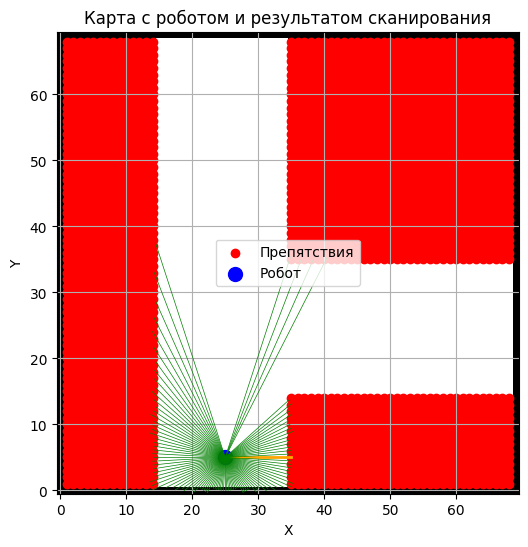

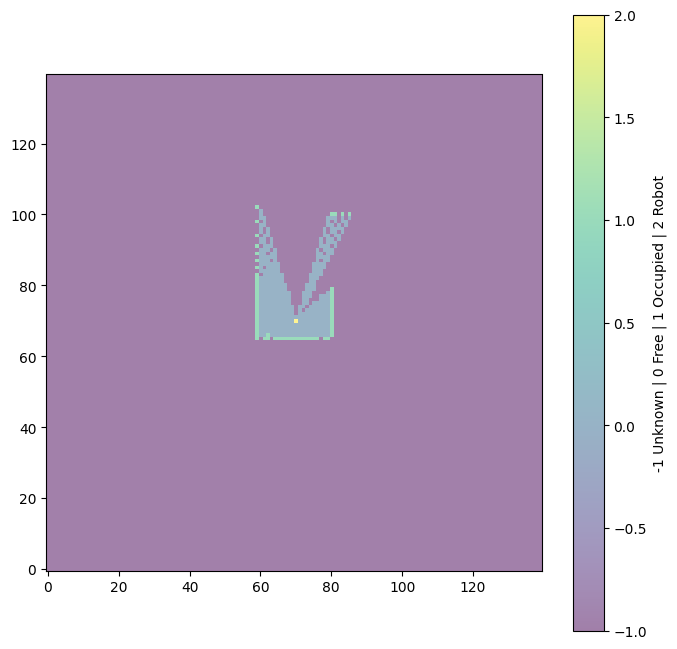

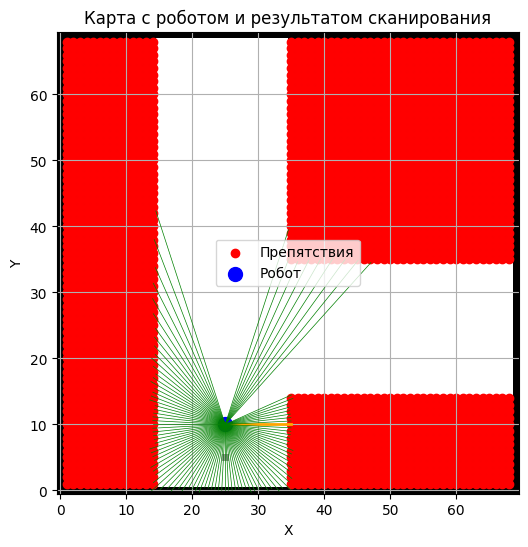

actual_diff_x_accum=0.0, actual_diff_y_accum=5.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=0.172643129516669, estimated_diff_y_accum=4.8101067959220325, estimated_diff_theta_accum=0.043592440968219896
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=584
i=1 Grid and Map area diff: 71.37%


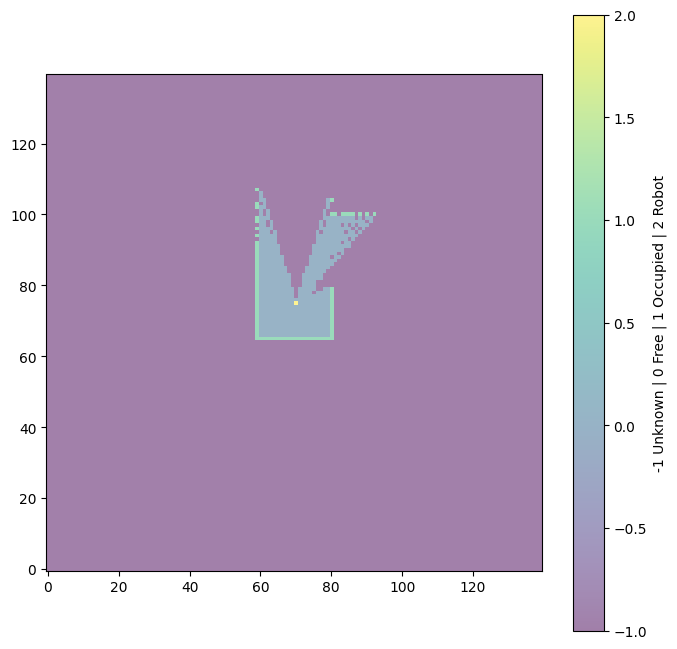

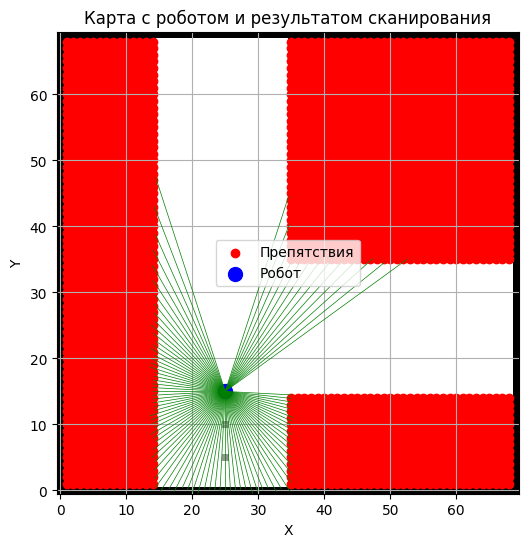

actual_diff_x_accum=0.0, actual_diff_y_accum=10.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=0.13372084456429184, estimated_diff_y_accum=9.522157020762076, estimated_diff_theta_accum=0.06595358661691775
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=725
i=2 Grid and Map area diff: 64.46%


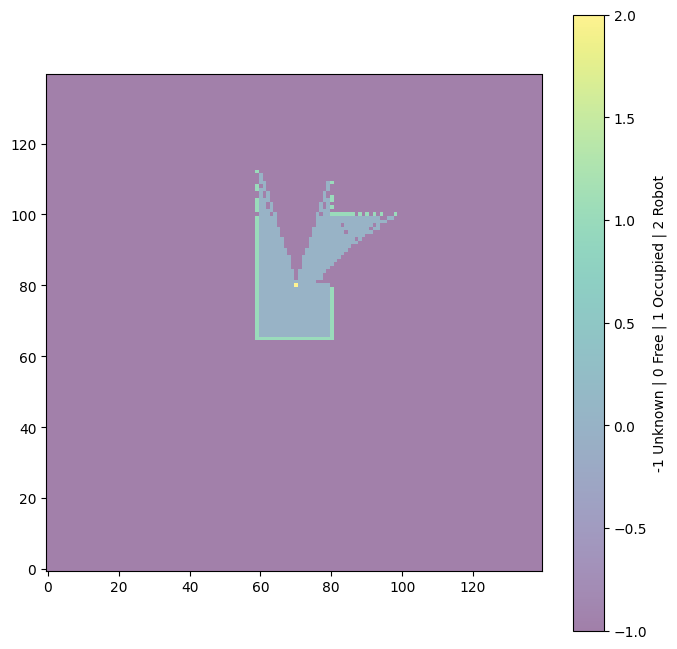

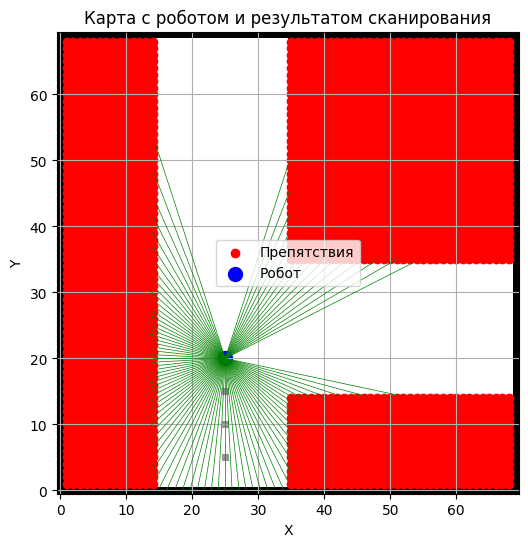

actual_diff_x_accum=0.0, actual_diff_y_accum=15.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-0.6618073328791292, estimated_diff_y_accum=13.882092616705838, estimated_diff_theta_accum=0.061481446935139995
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=889
i=3 Grid and Map area diff: 56.42%


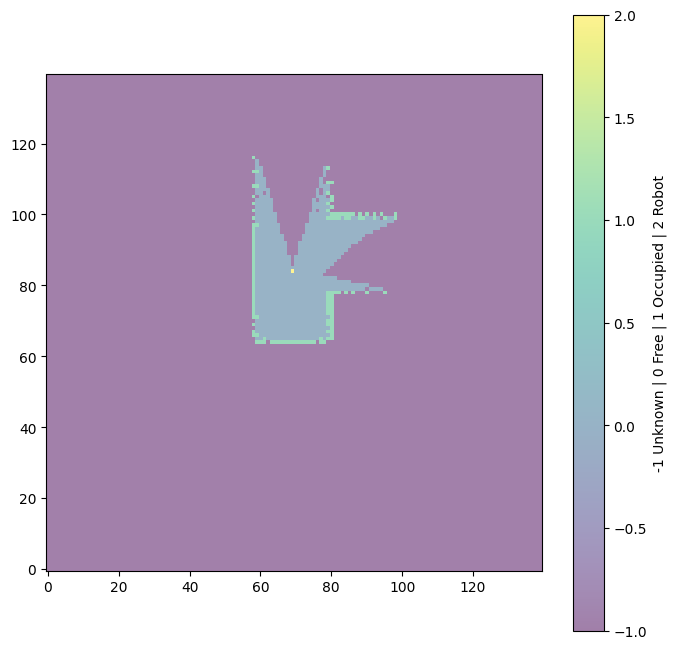

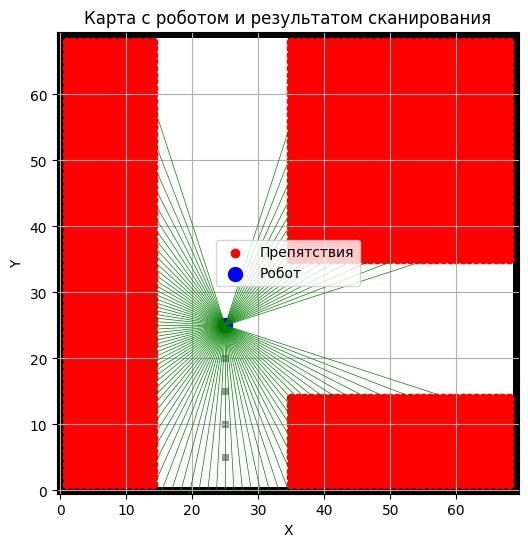

actual_diff_x_accum=0.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-0.9315718122134482, estimated_diff_y_accum=18.42961723853126, estimated_diff_theta_accum=0.06780601279645289
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1029
i=4 Grid and Map area diff: 49.56%


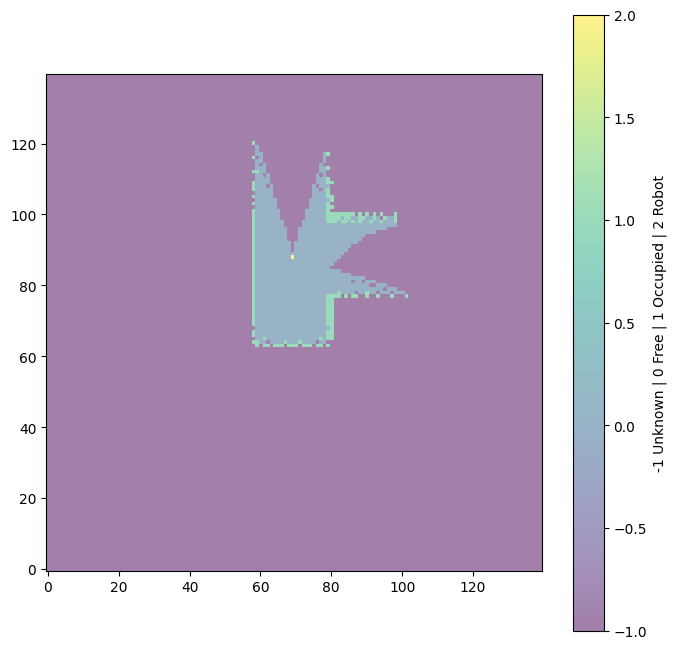

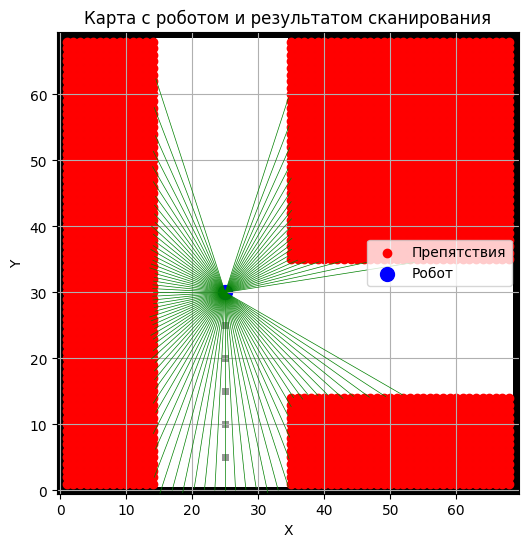

actual_diff_x_accum=0.0, actual_diff_y_accum=25.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-0.9129904108297734, estimated_diff_y_accum=22.891126319447523, estimated_diff_theta_accum=0.07227815247823063
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1145
i=5 Grid and Map area diff: 43.87%


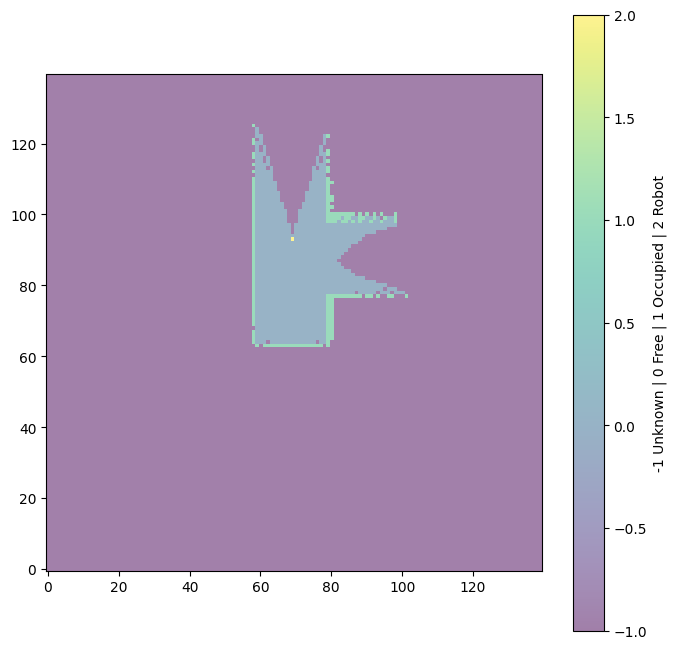

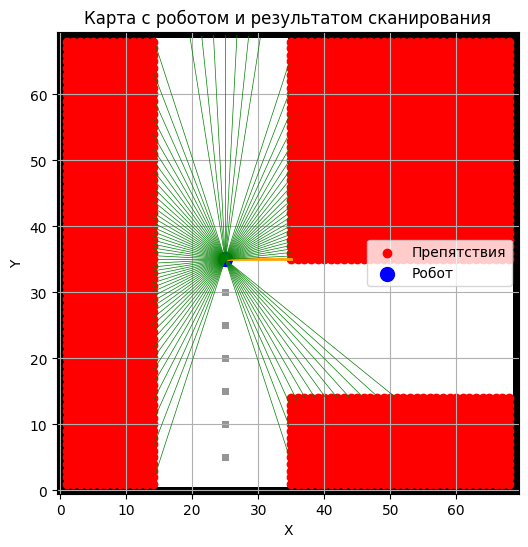

actual_diff_x_accum=0.0, actual_diff_y_accum=30.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-0.9216078239291502, estimated_diff_y_accum=24.4117156318937, estimated_diff_theta_accum=0.1370969061206454
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1382
i=6 Grid and Map area diff: 32.25%


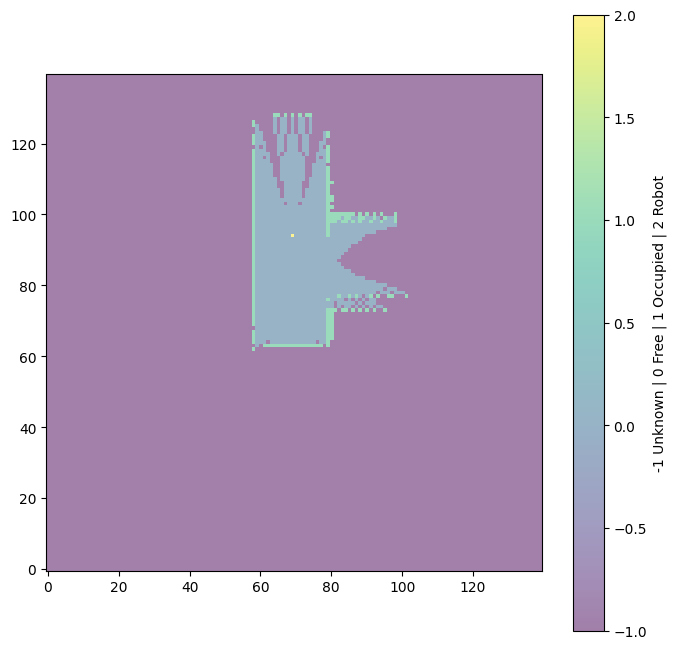

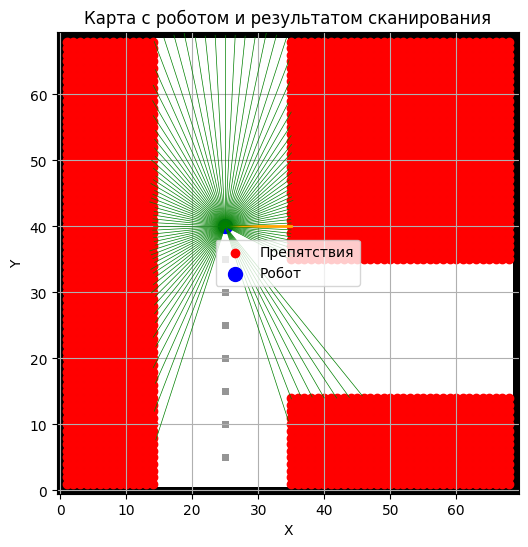

actual_diff_x_accum=0.0, actual_diff_y_accum=35.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-0.926969603489267, estimated_diff_y_accum=28.88057389255231, estimated_diff_theta_accum=0.1370969061206454
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1531
i=7 Grid and Map area diff: 24.95%


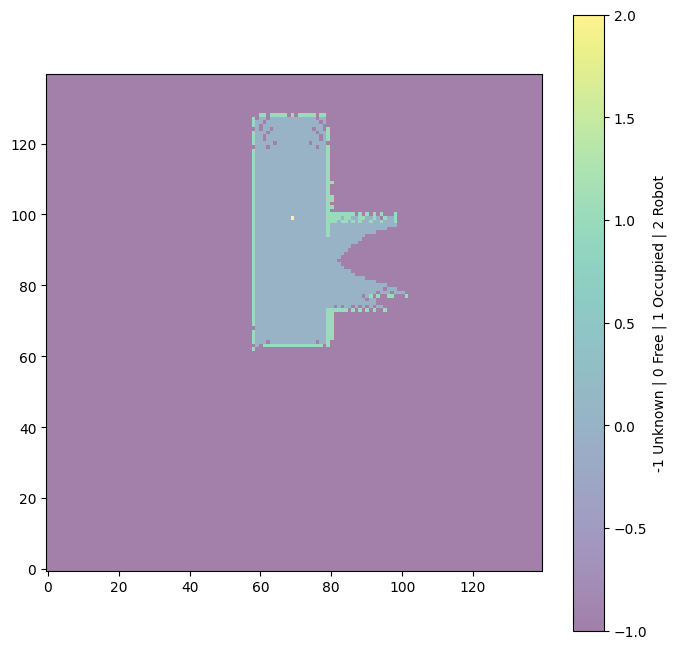

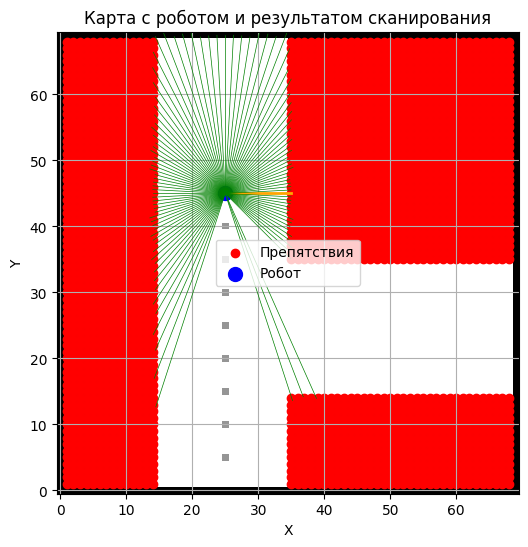

actual_diff_x_accum=0.0, actual_diff_y_accum=40.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-0.9593565178692924, estimated_diff_y_accum=33.598414653448465, estimated_diff_theta_accum=0.13262476643886764
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1550
i=8 Grid and Map area diff: 24.02%


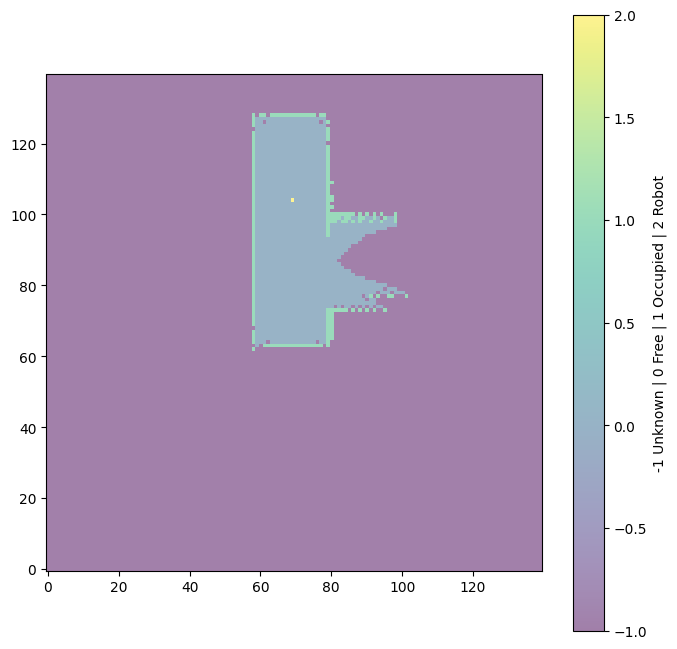

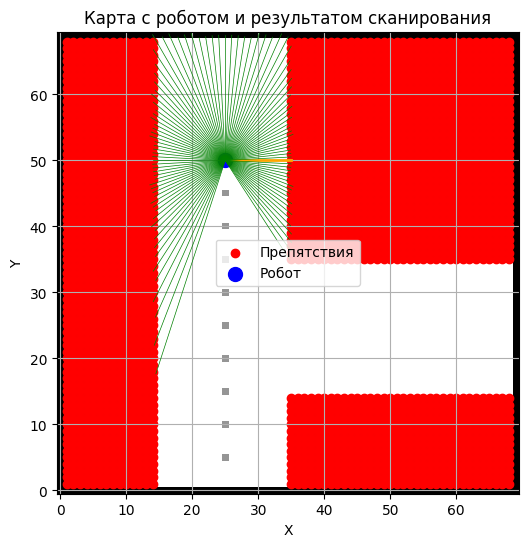

actual_diff_x_accum=0.0, actual_diff_y_accum=45.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-0.9575780090011945, estimated_diff_y_accum=38.397305117878496, estimated_diff_theta_accum=0.13262476643886764
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1533
i=9 Grid and Map area diff: 24.85%


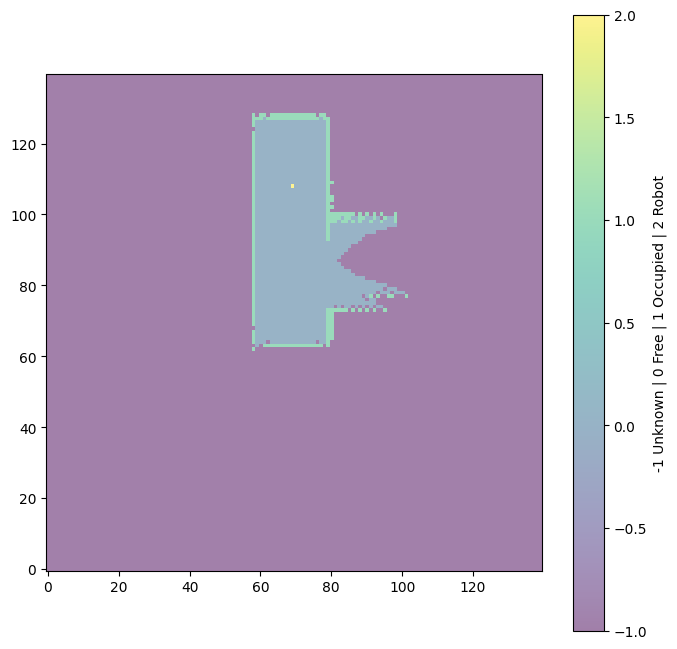

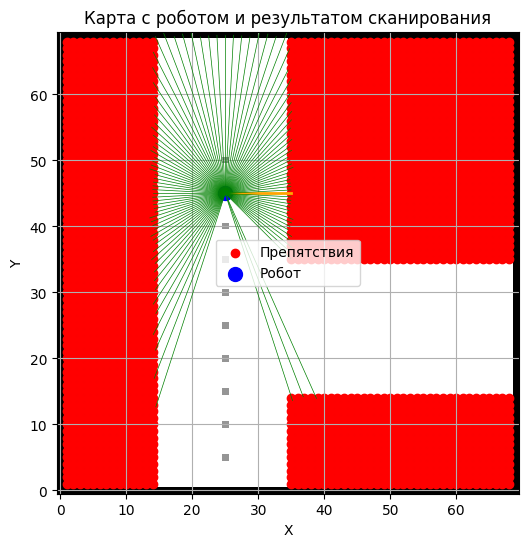

actual_diff_x_accum=0.0, actual_diff_y_accum=40.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-1.1140081997863185, estimated_diff_y_accum=35.63775059110384, estimated_diff_theta_accum=-0.0614320010753891
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1577
i=10 Grid and Map area diff: 22.70%


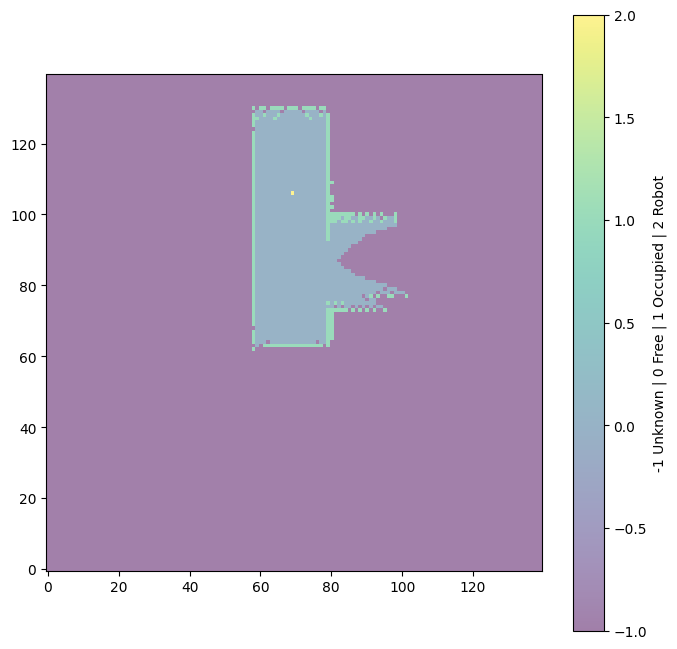

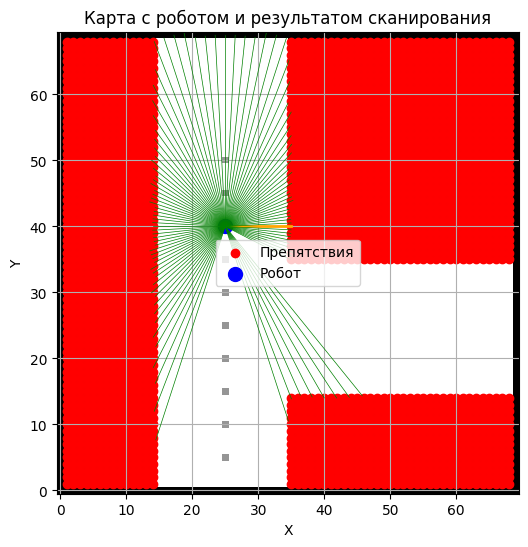

actual_diff_x_accum=0.0, actual_diff_y_accum=35.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-1.1639624602404544, estimated_diff_y_accum=31.20523573506056, estimated_diff_theta_accum=-0.09305609544101671
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1579
i=11 Grid and Map area diff: 22.60%


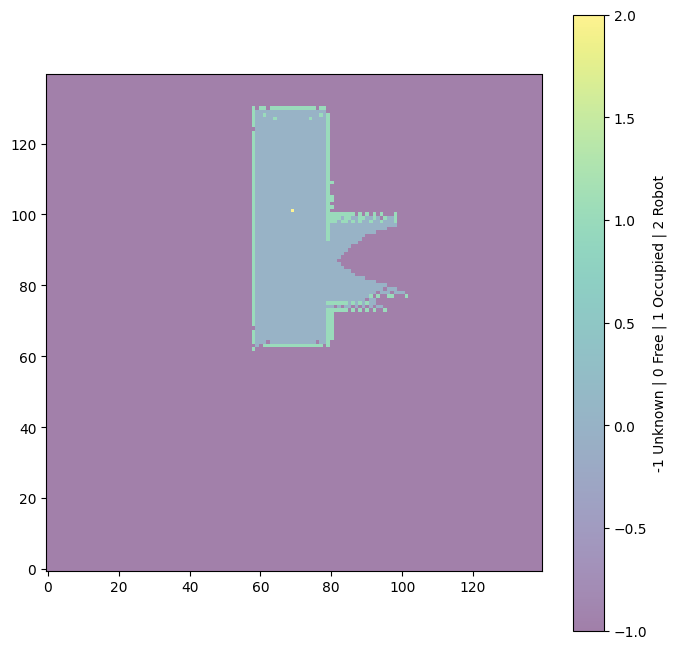

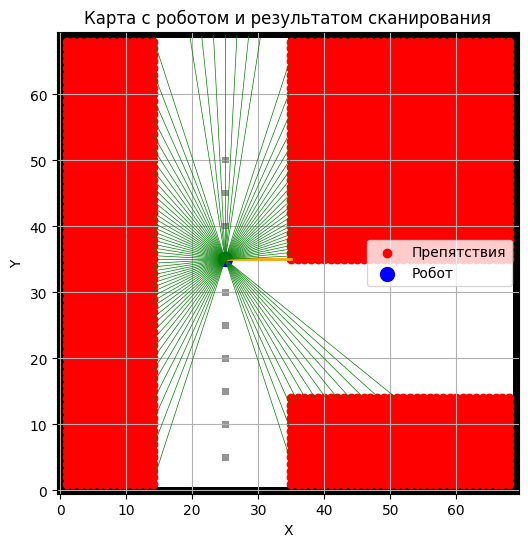

actual_diff_x_accum=0.0, actual_diff_y_accum=30.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-1.2167808548015036, estimated_diff_y_accum=26.948153729455846, estimated_diff_theta_accum=-0.11149544558602115
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1587
i=12 Grid and Map area diff: 22.21%


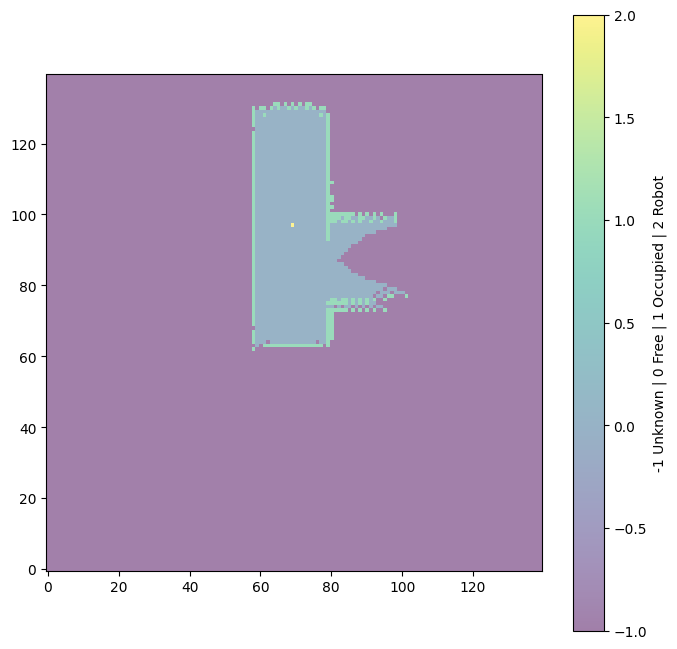

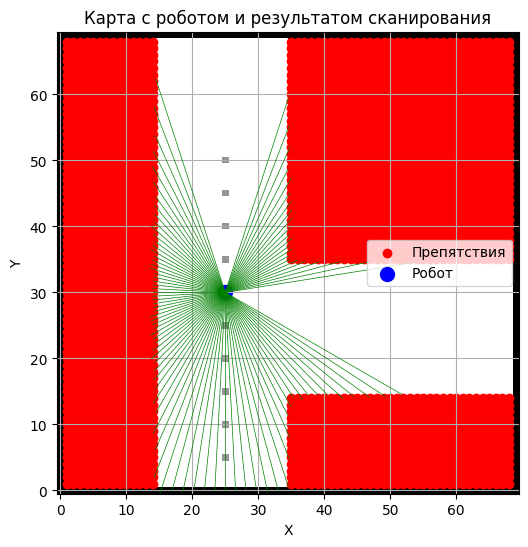

actual_diff_x_accum=0.0, actual_diff_y_accum=25.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-1.7905031950094463, estimated_diff_y_accum=25.12400303323753, estimated_diff_theta_accum=-0.14343424192829357
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1628
i=13 Grid and Map area diff: 20.20%


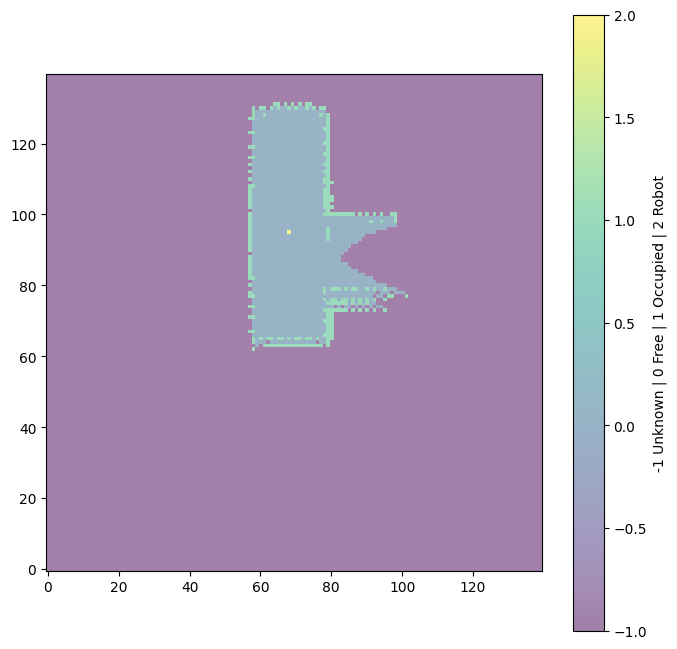

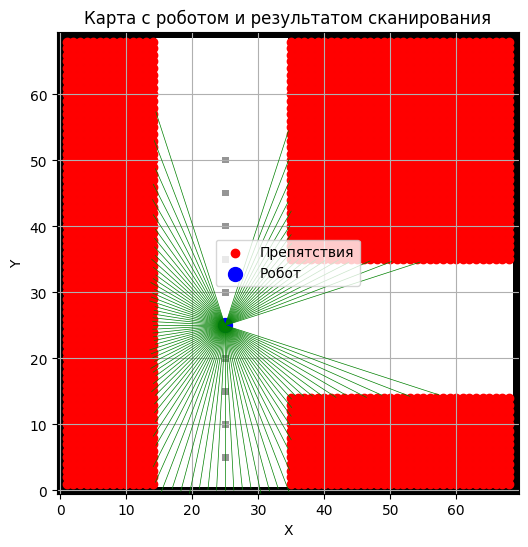

actual_diff_x_accum=0.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=-2.000531733880962, estimated_diff_y_accum=20.025971901860807, estimated_diff_theta_accum=-0.14343424192829357
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1635
i=14 Grid and Map area diff: 19.85%


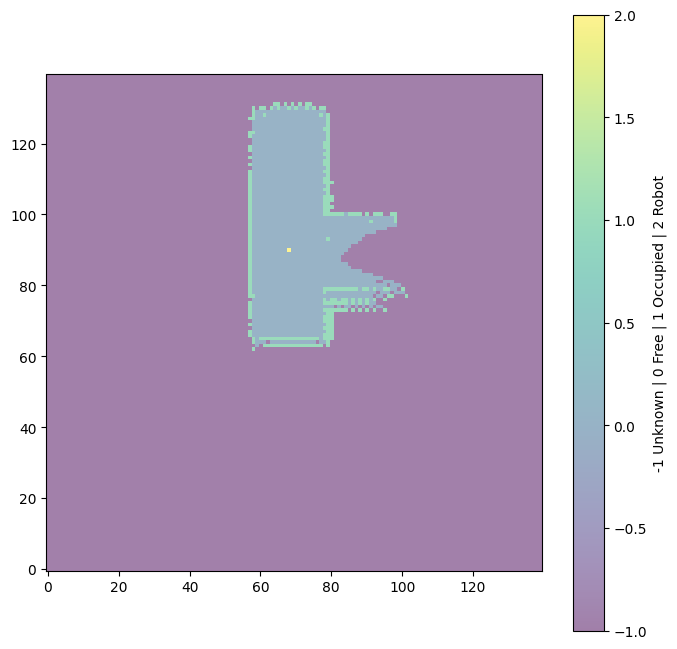

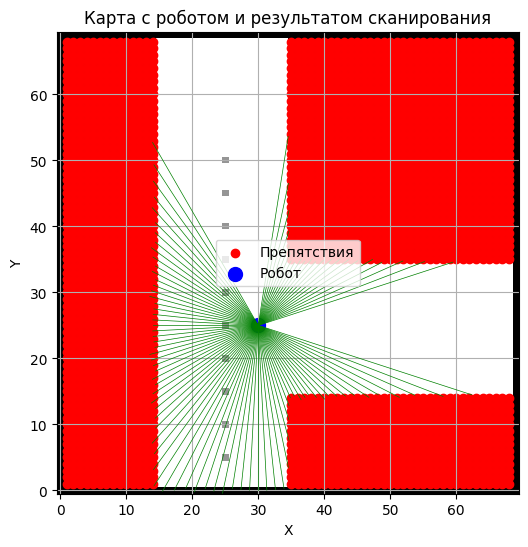

actual_diff_x_accum=5.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=2.7193399440421073, estimated_diff_y_accum=19.96500377629659, estimated_diff_theta_accum=-0.14343424192829357
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1667
i=15 Grid and Map area diff: 18.28%


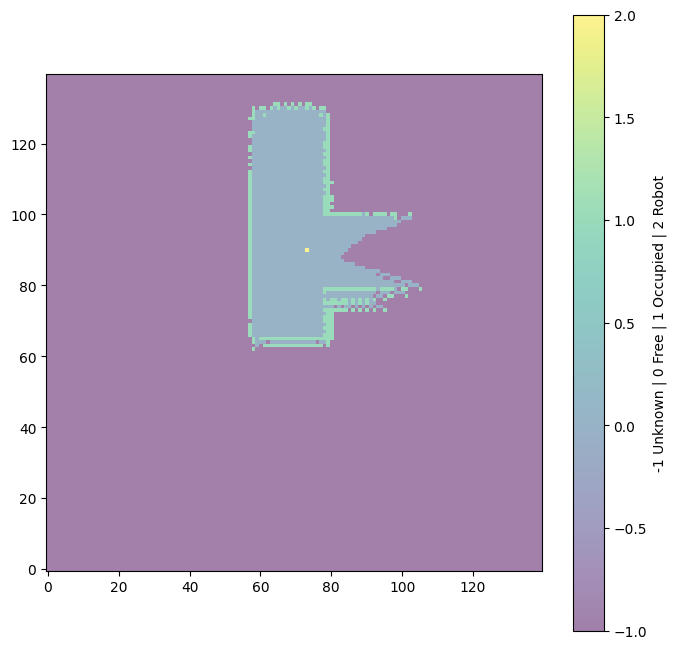

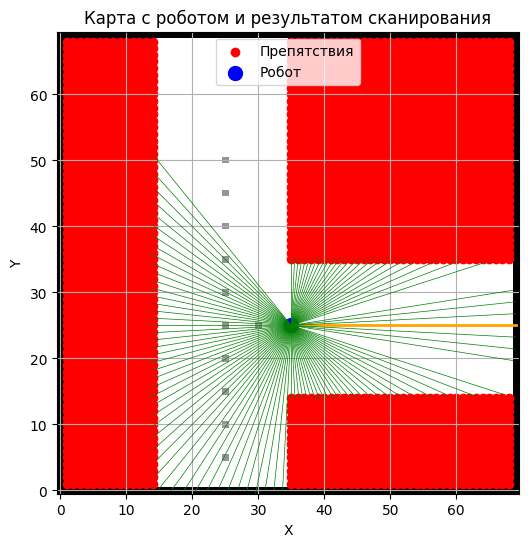

actual_diff_x_accum=10.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=6.042027921887211, estimated_diff_y_accum=19.535594502440382, estimated_diff_theta_accum=-0.14343424192829357
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=1935
i=16 Grid and Map area diff: 5.15%


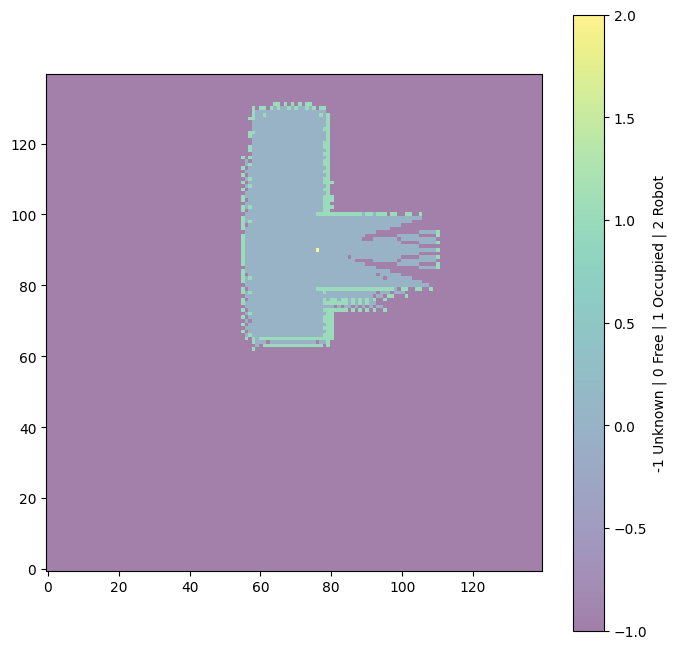

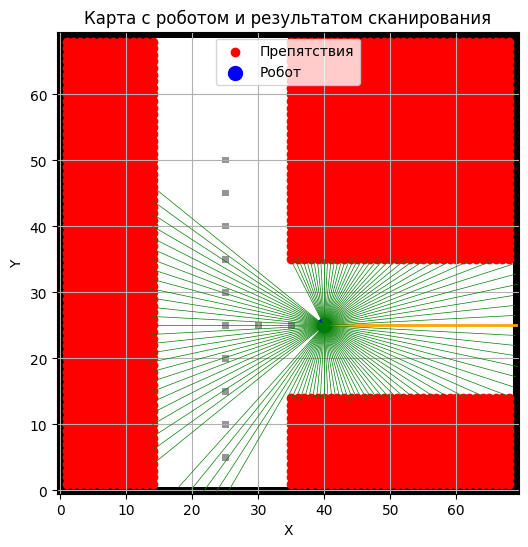

actual_diff_x_accum=15.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=10.779269354760467, estimated_diff_y_accum=19.463421123353925, estimated_diff_theta_accum=-0.13710967606698068
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=2056
i=17 Grid and Map area diff: 0.78%


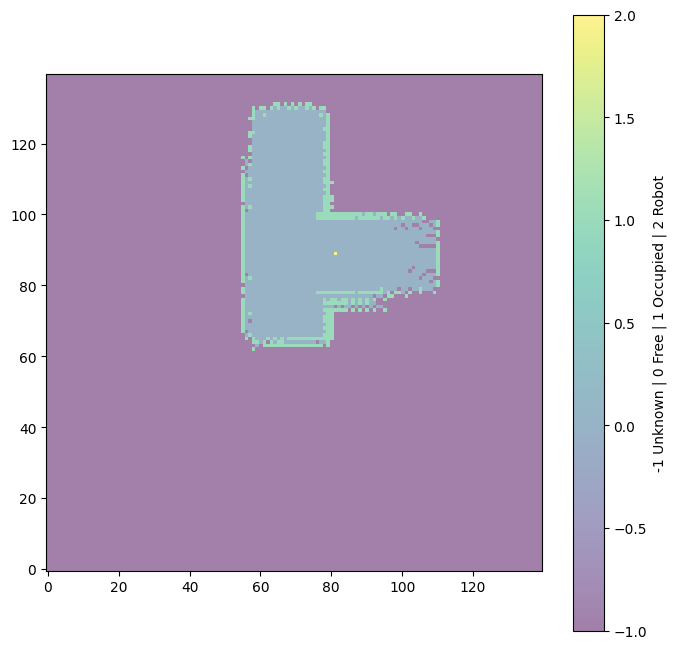

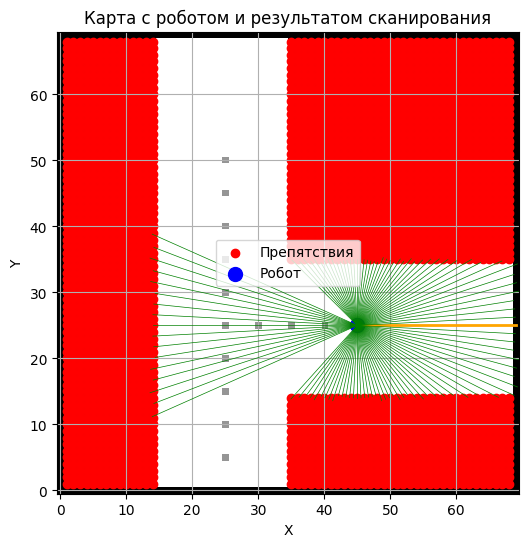

actual_diff_x_accum=20.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=15.641369621054086, estimated_diff_y_accum=19.463756771555392, estimated_diff_theta_accum=-0.13263753638520293
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=2079
i=18 Grid and Map area diff: 1.91%


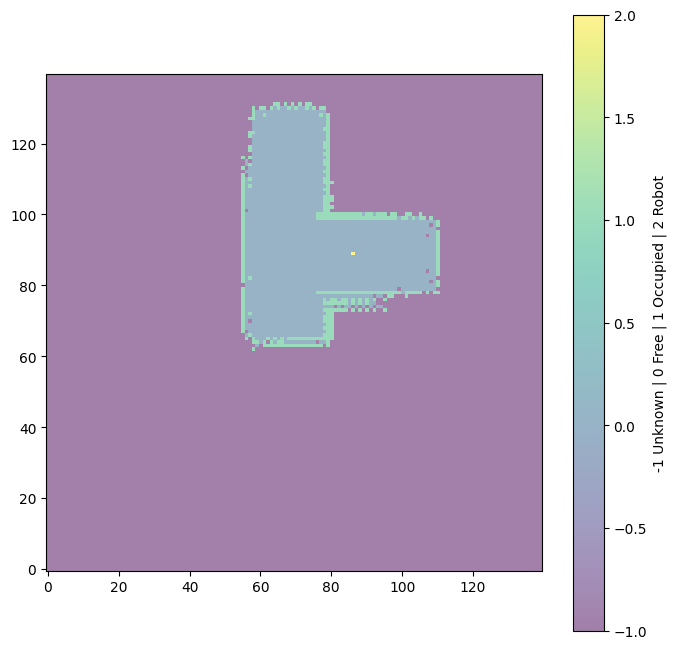

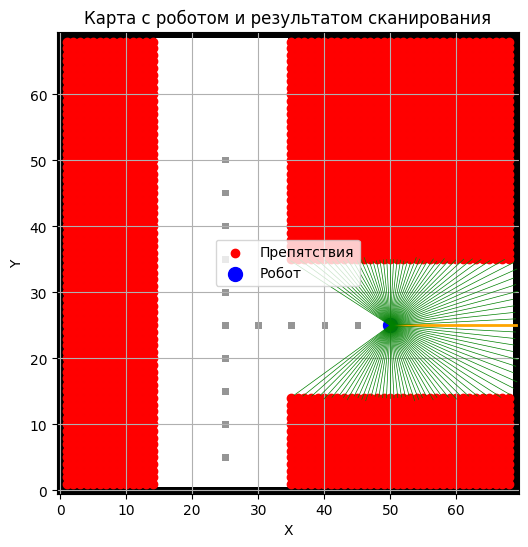

actual_diff_x_accum=25.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=11.838517000390123, estimated_diff_y_accum=19.5573979994719, estimated_diff_theta_accum=0.09021939706684678
Actual room area: total_tiles=4900 free_tiles=2040
Occupancy grid map area: free_tiles=2046
i=19 Grid and Map area diff: 0.29%


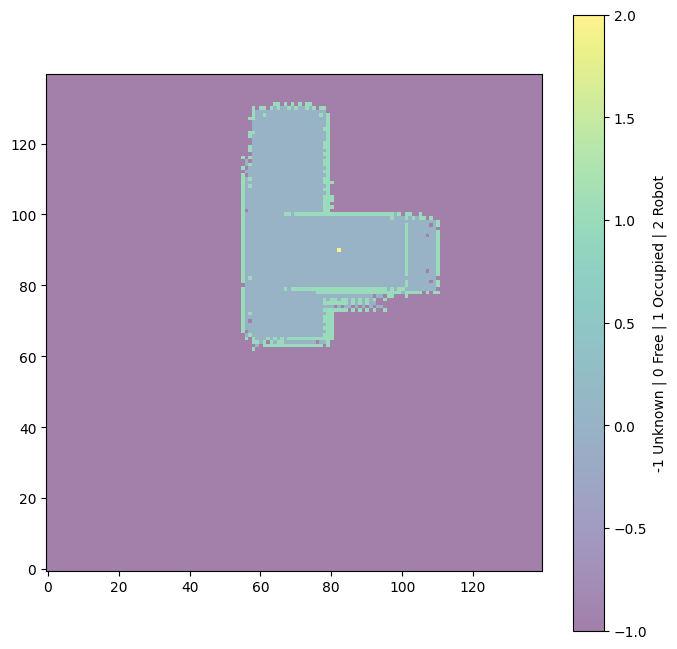

In [270]:
conduct_experiment(room_test_setup1)

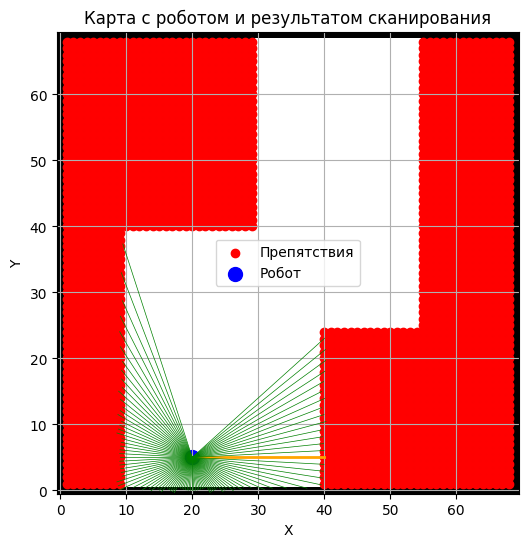

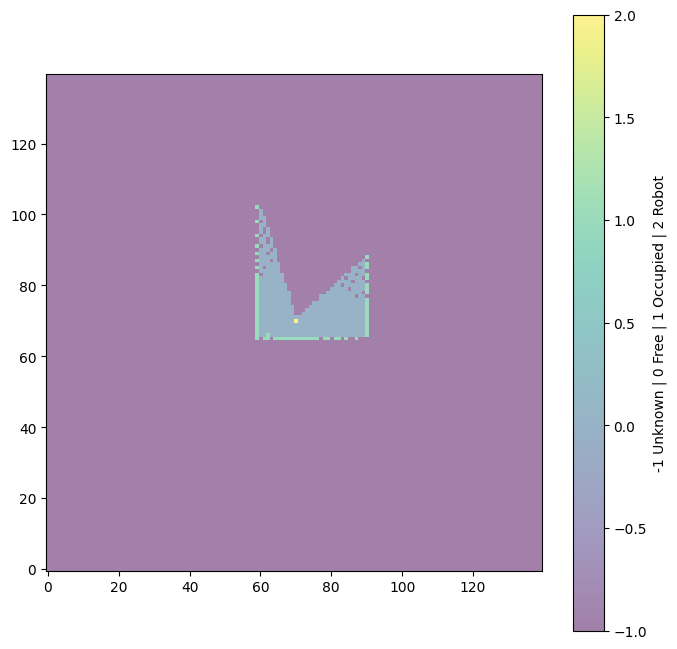

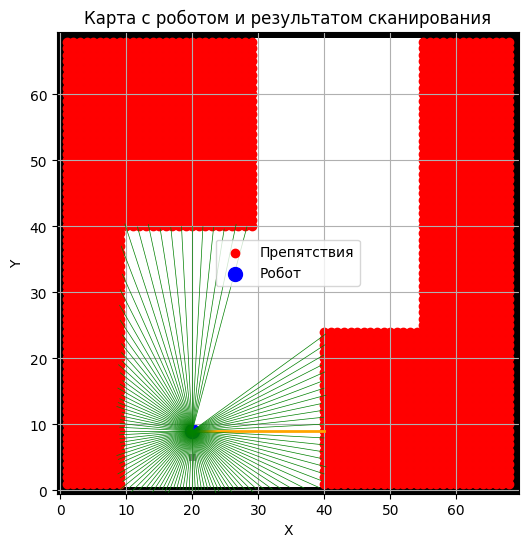

actual_diff_x_accum=0.0, actual_diff_y_accum=4.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=1.29463027435893, estimated_diff_y_accum=2.5168126323956375, estimated_diff_theta_accum=0.2416267794293229
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=827
i=1 Grid and Map area diff: 60.99%


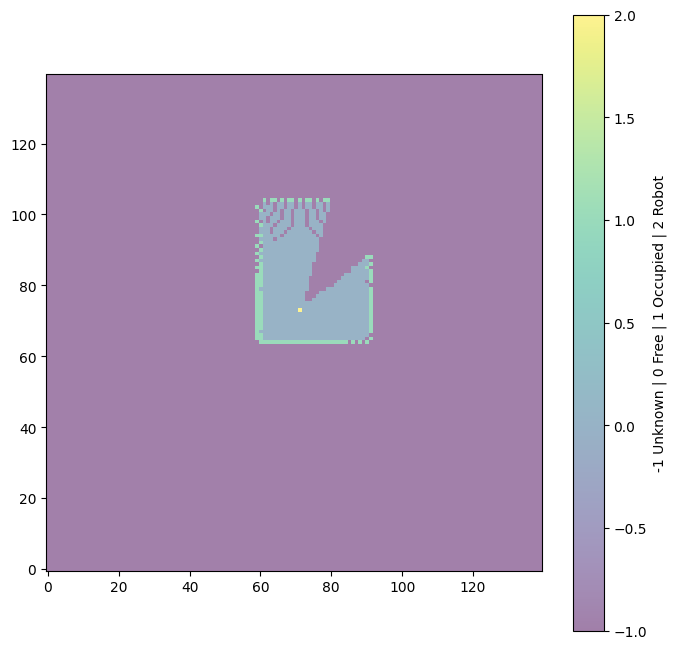

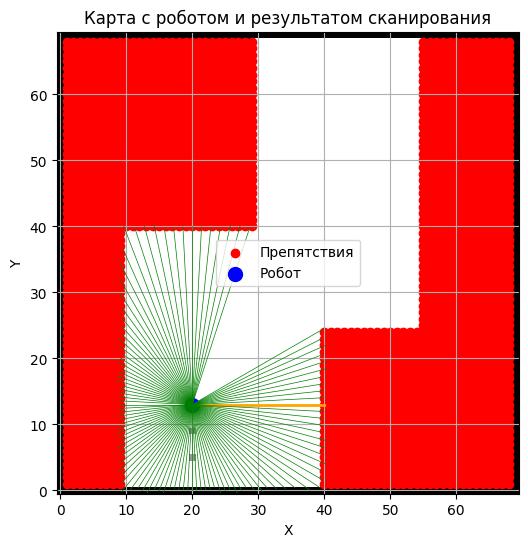

actual_diff_x_accum=0.0, actual_diff_y_accum=8.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=1.233878877900545, estimated_diff_y_accum=6.581285048096728, estimated_diff_theta_accum=0.23067227350622904
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=901
i=2 Grid and Map area diff: 57.50%


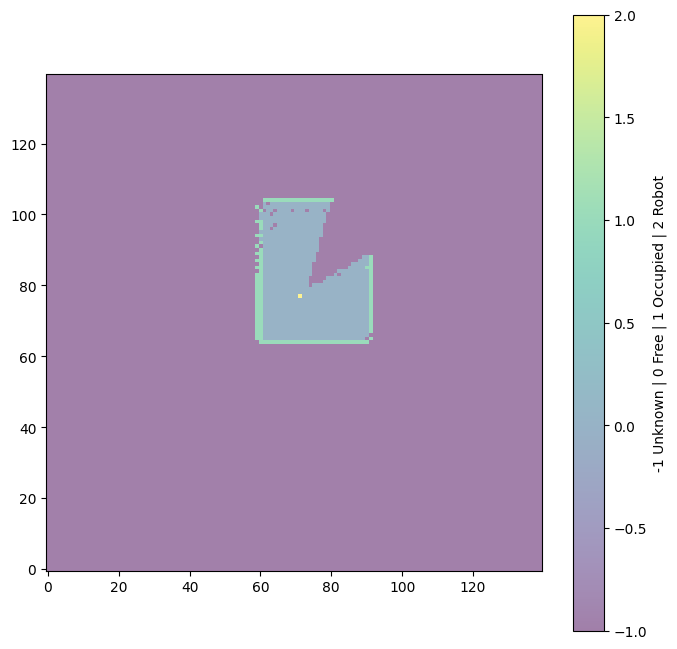

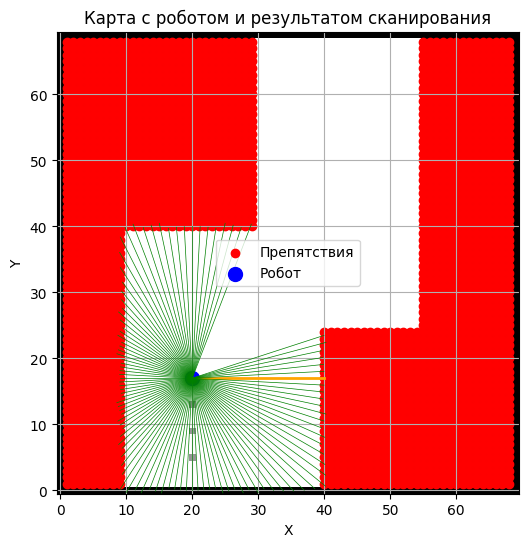

actual_diff_x_accum=0.0, actual_diff_y_accum=12.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=1.2508523870375357, estimated_diff_y_accum=10.735413365499289, estimated_diff_theta_accum=0.23067227350622904
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=930
i=3 Grid and Map area diff: 56.13%


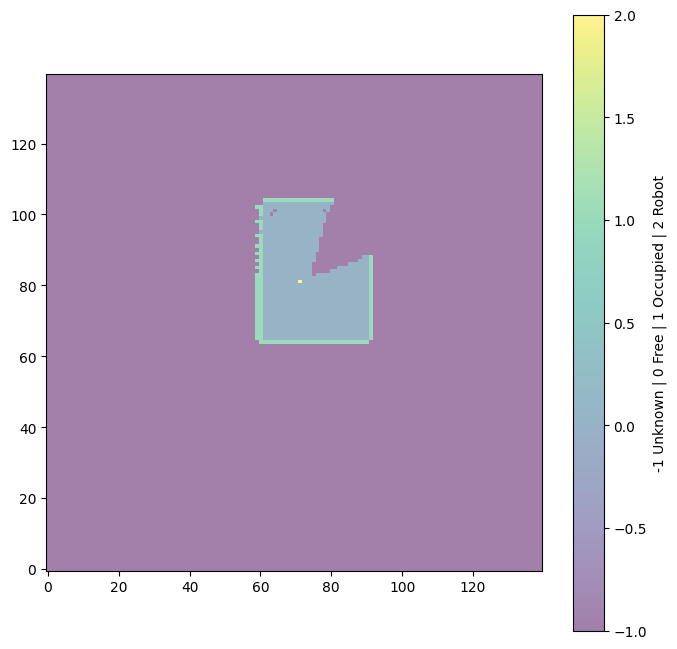

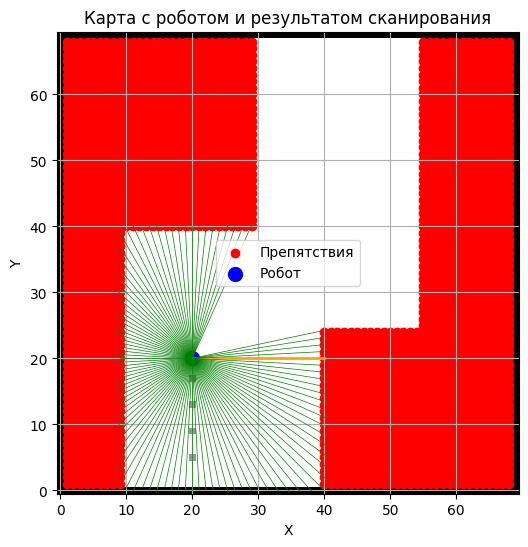

actual_diff_x_accum=0.0, actual_diff_y_accum=15.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=1.3060828224737835, estimated_diff_y_accum=13.73773765379541, estimated_diff_theta_accum=0.23699683936754193
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=953
i=4 Grid and Map area diff: 55.05%


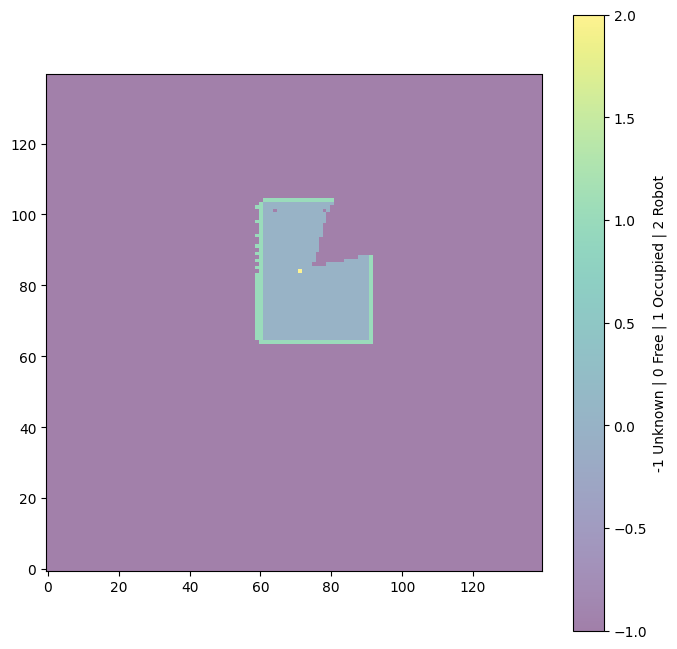

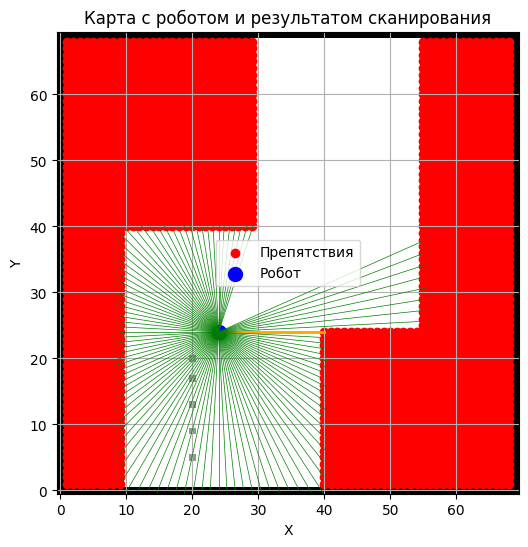

actual_diff_x_accum=4.0, actual_diff_y_accum=19.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=3.310608360294731, estimated_diff_y_accum=16.472030621662952, estimated_diff_theta_accum=0.16857296678068695
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=1198
i=5 Grid and Map area diff: 43.49%


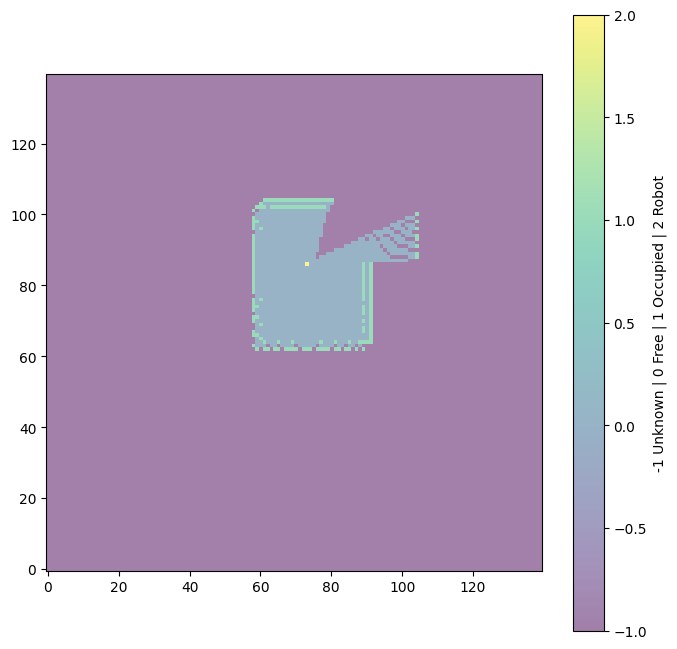

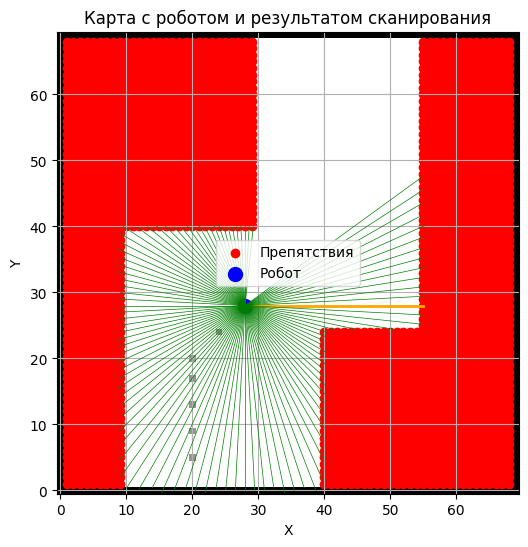

actual_diff_x_accum=8.0, actual_diff_y_accum=23.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=7.311899480582795, estimated_diff_y_accum=20.096619012066636, estimated_diff_theta_accum=0.11738144176679531
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=1391
i=6 Grid and Map area diff: 34.39%


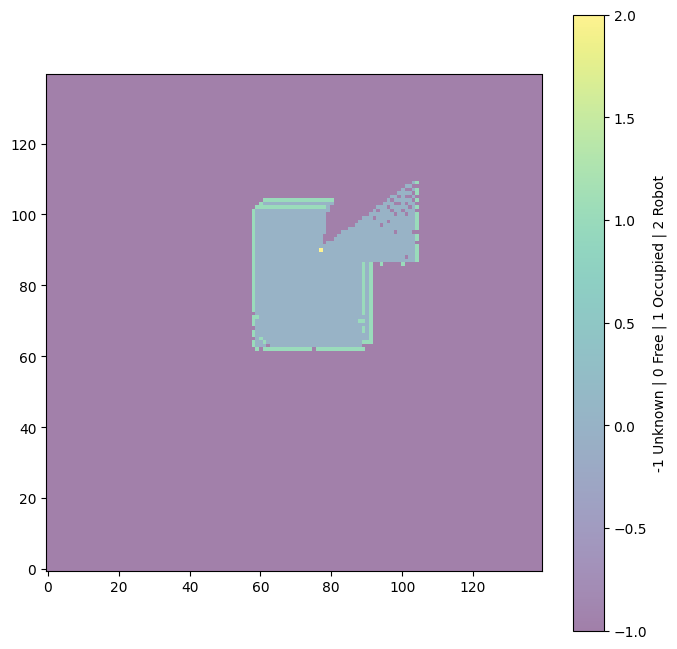

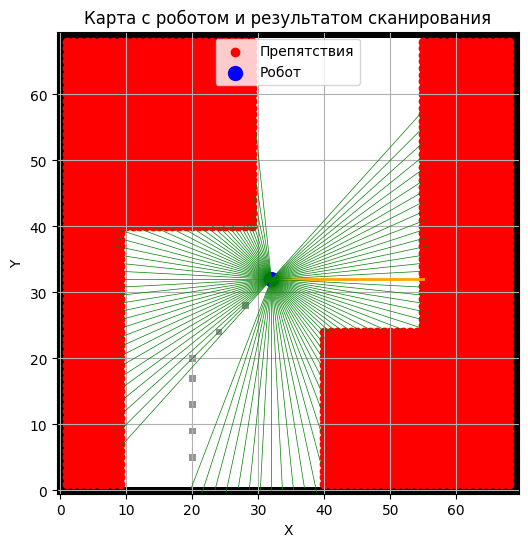

actual_diff_x_accum=12.0, actual_diff_y_accum=27.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=11.129934388352375, estimated_diff_y_accum=23.00888779015111, estimated_diff_theta_accum=0.07788203870557192
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=1537
i=7 Grid and Map area diff: 27.50%


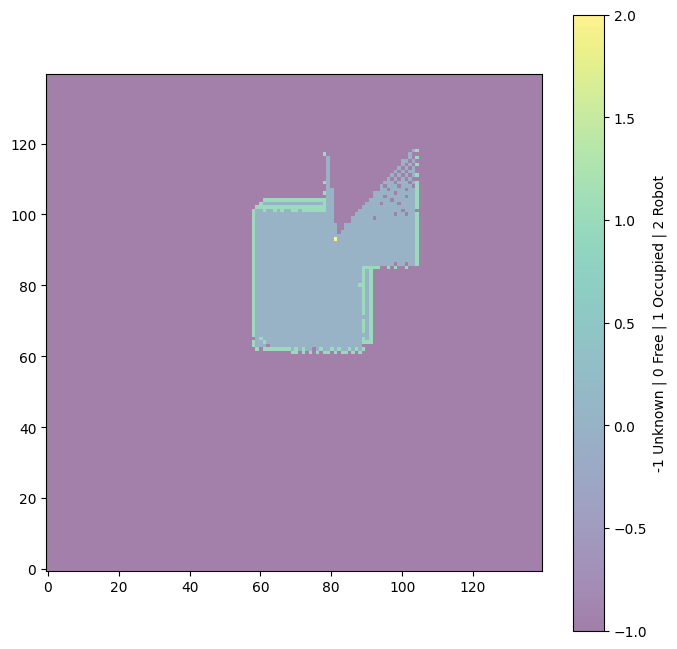

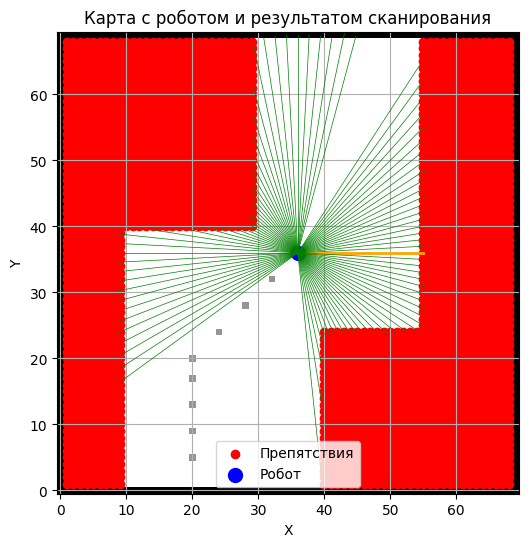

actual_diff_x_accum=16.0, actual_diff_y_accum=31.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=13.969730247156386, estimated_diff_y_accum=22.675255740748632, estimated_diff_theta_accum=0.08971426729379028
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=1874
i=8 Grid and Map area diff: 11.60%


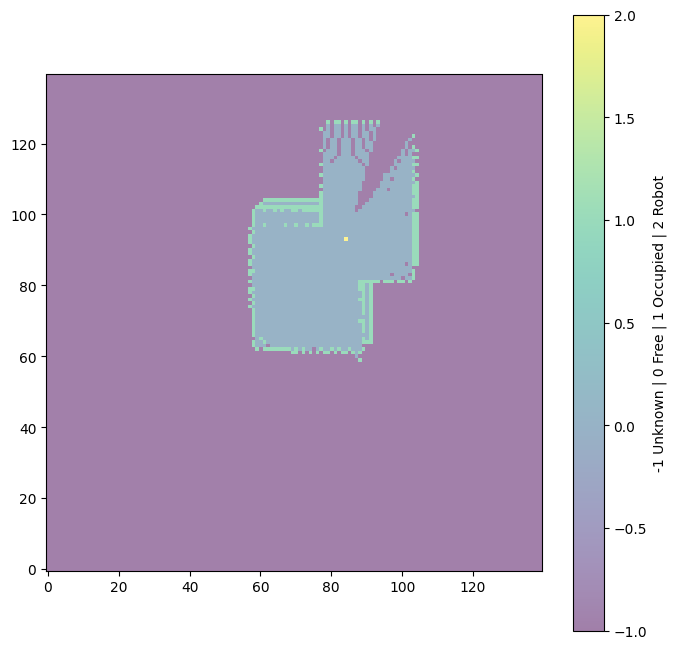

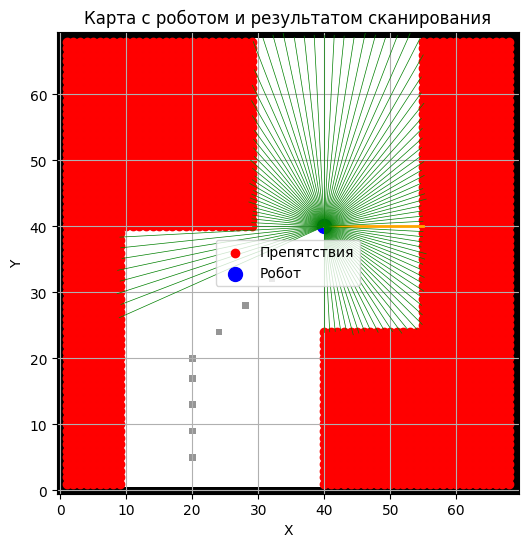

actual_diff_x_accum=20.0, actual_diff_y_accum=35.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=17.92274054143238, estimated_diff_y_accum=26.110474275995777, estimated_diff_theta_accum=0.08971426729379028
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2040
i=9 Grid and Map area diff: 3.77%


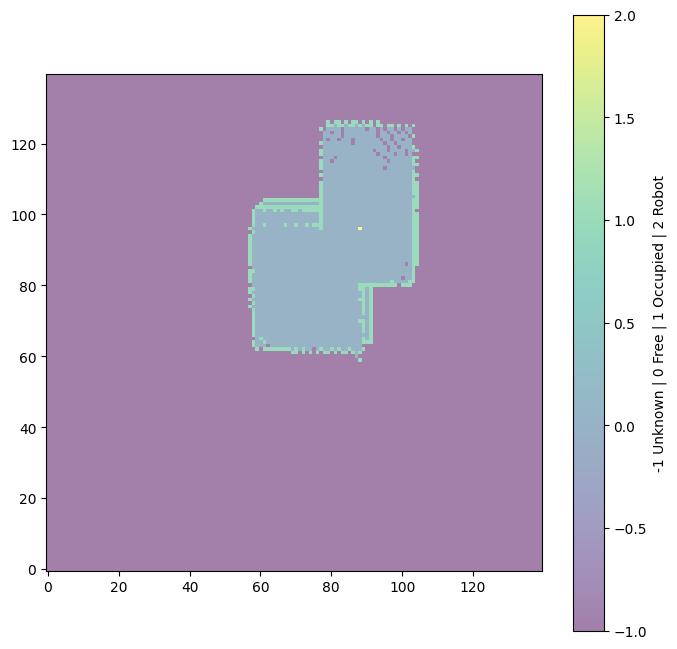

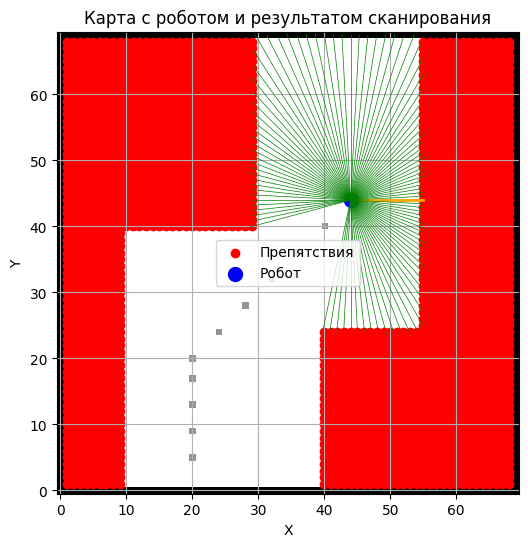

actual_diff_x_accum=24.0, actual_diff_y_accum=39.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=21.948031903440025, estimated_diff_y_accum=30.077876704984764, estimated_diff_theta_accum=0.09603883315510317
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2072
i=10 Grid and Map area diff: 2.26%


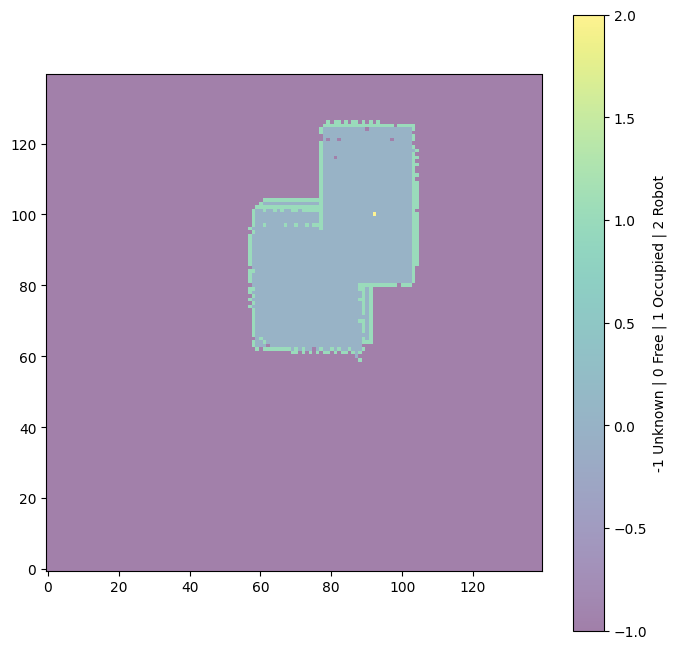

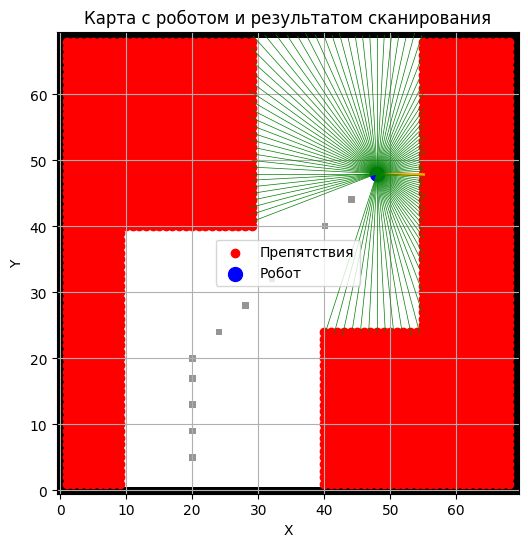

actual_diff_x_accum=28.0, actual_diff_y_accum=43.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=25.982836972735566, estimated_diff_y_accum=34.208214116168875, estimated_diff_theta_accum=0.10051097283688092
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2077
i=11 Grid and Map area diff: 2.03%


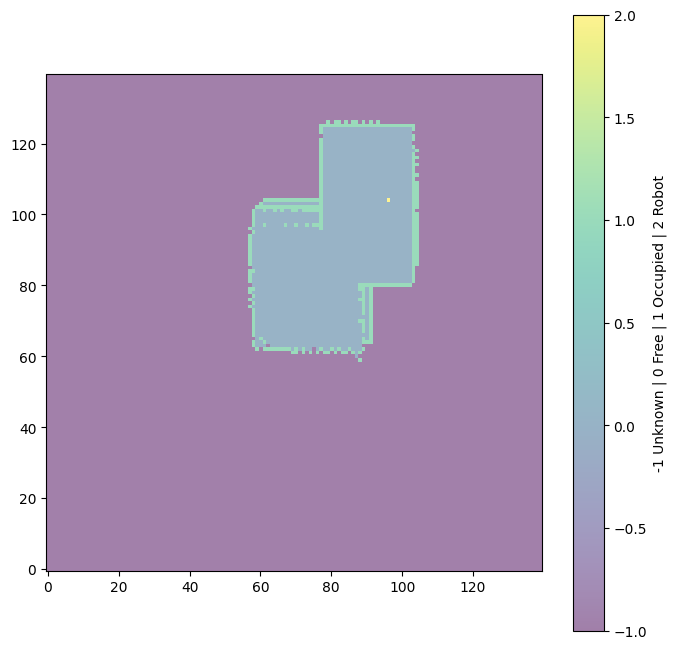

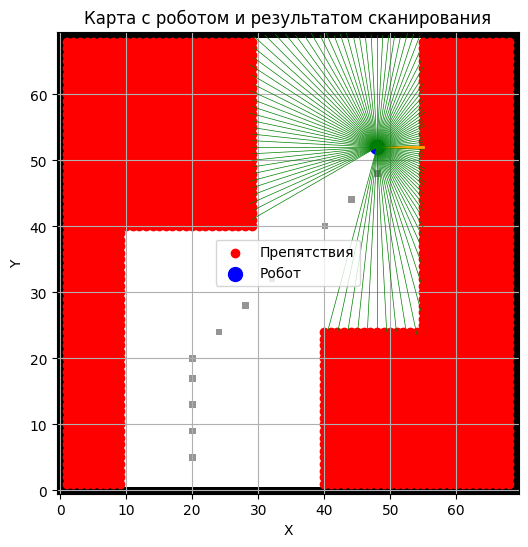

actual_diff_x_accum=28.0, actual_diff_y_accum=47.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=25.977857967807033, estimated_diff_y_accum=38.097220418598724, estimated_diff_theta_accum=0.09603883315510317
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2076
i=12 Grid and Map area diff: 2.08%


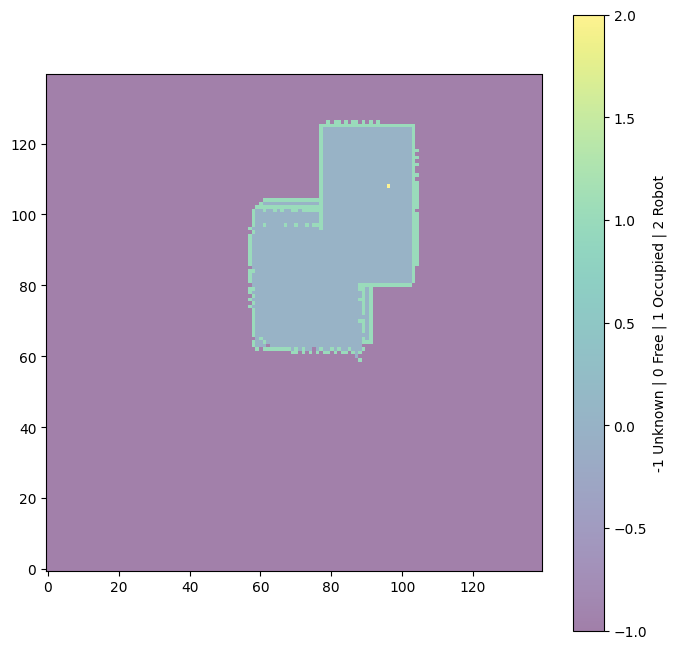

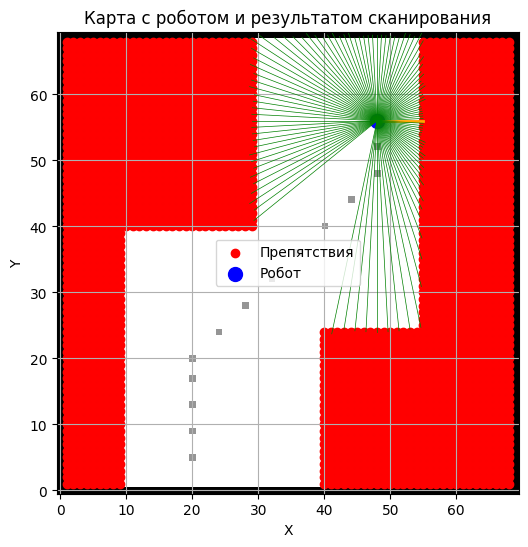

actual_diff_x_accum=28.0, actual_diff_y_accum=51.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=25.97484495764872, estimated_diff_y_accum=42.11831680253439, estimated_diff_theta_accum=0.09156669347332543
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2076
i=13 Grid and Map area diff: 2.08%


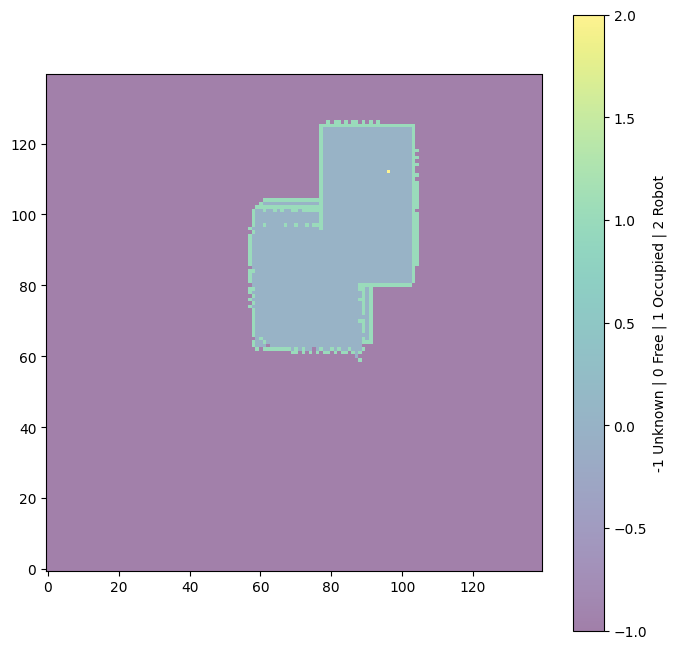

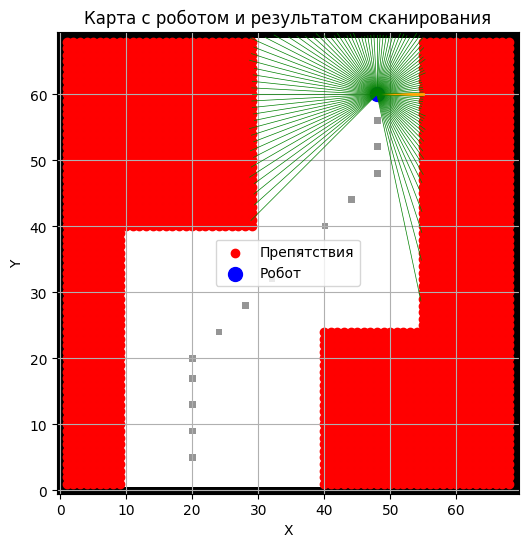

actual_diff_x_accum=28.0, actual_diff_y_accum=55.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=25.95233990577102, estimated_diff_y_accum=46.250062579060675, estimated_diff_theta_accum=0.1015667351404603
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2076
i=14 Grid and Map area diff: 2.08%


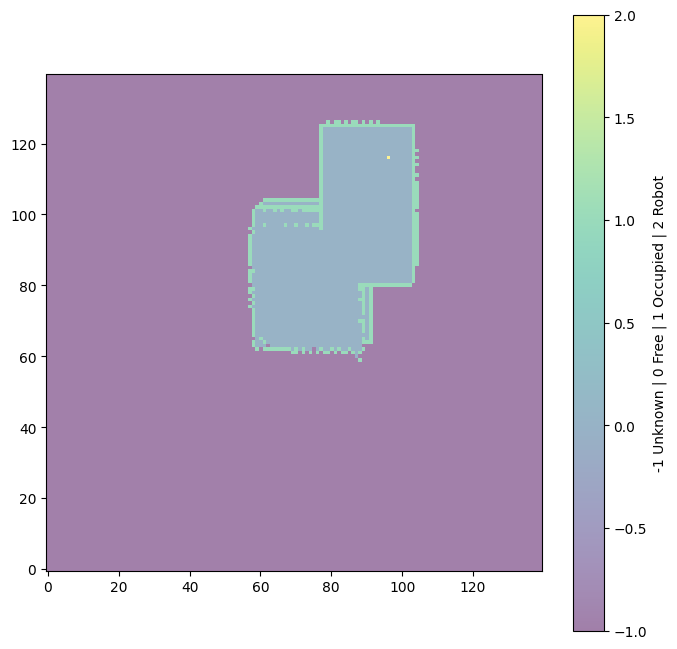

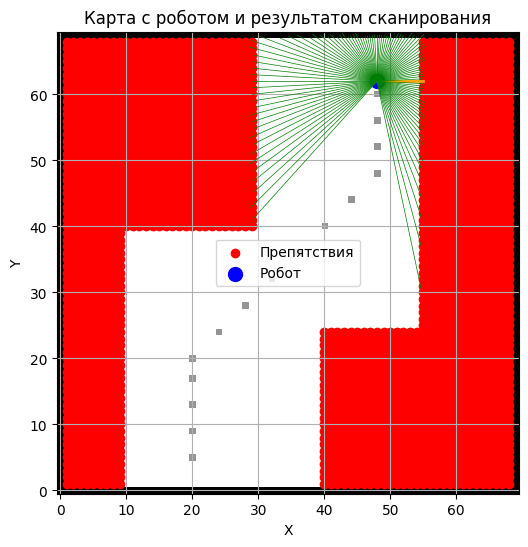

actual_diff_x_accum=28.0, actual_diff_y_accum=57.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=26.052154767531395, estimated_diff_y_accum=47.9989219205708, estimated_diff_theta_accum=0.08891754017086703
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2076
i=15 Grid and Map area diff: 2.08%


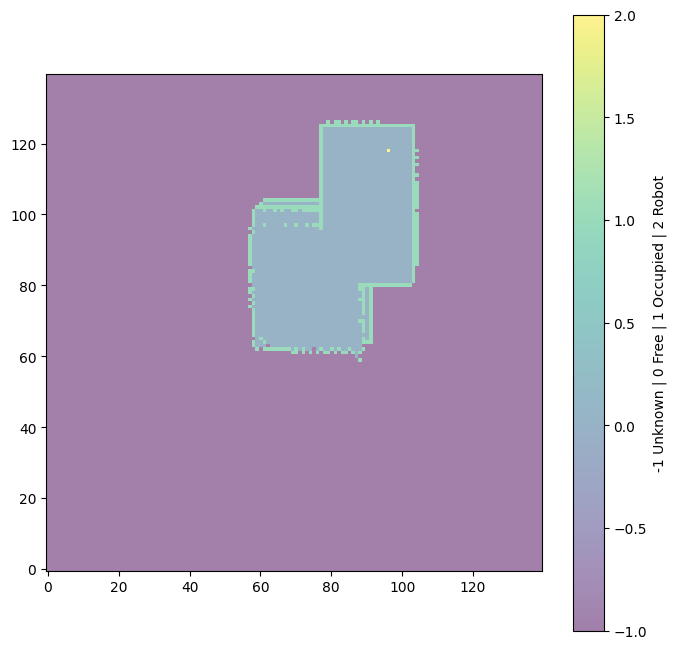

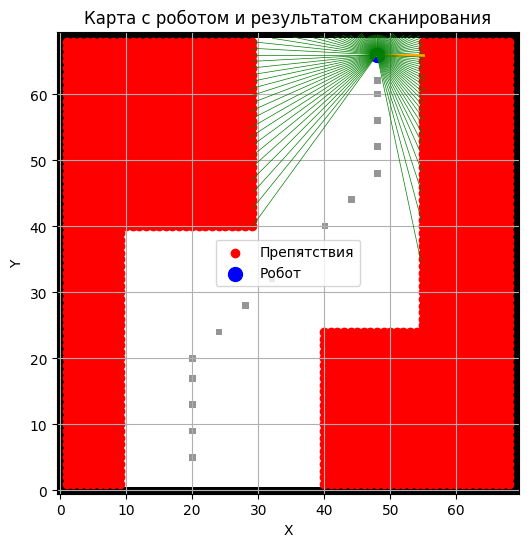

actual_diff_x_accum=28.0, actual_diff_y_accum=61.0, actual_diff_theta_accum=0.0
estimated_diff_x_accum=26.072227692731694, estimated_diff_y_accum=52.10492287432217, estimated_diff_theta_accum=0.08891754017086703
Actual room area: total_tiles=4900 free_tiles=2120
Occupancy grid map area: free_tiles=2076
i=16 Grid and Map area diff: 2.08%


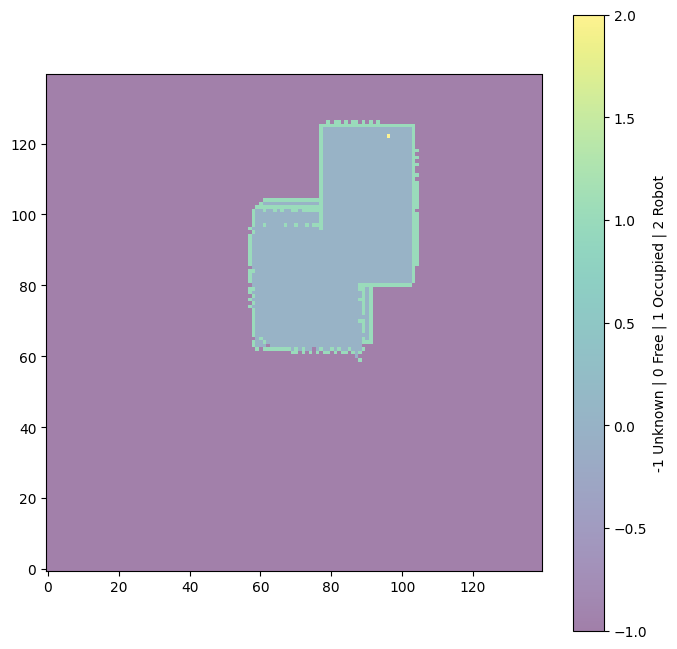

In [271]:
conduct_experiment(room_test_setup3)